# TODO LIST
- [x] Plot each iteration of the IF-EAKF (see posteriors getting narrower)
- [x] could try using weighted average (weighted by inverse variance) at every time step (could be numerically unstable)
- [x] over just mean over entire time series 
- [x] Run free simulation to see if it's close to data
- [x] keep everything the same except k
- [ ] how sensitive k is in which regions 
- [x] could learn a transformation of k (e.g., log(k))

In [56]:
%matplotlib inline

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff


# Simulate Data

In [57]:
import importlib
import simulate_data
importlib.reload(simulate_data)

<module 'simulate_data' from '/Users/hwunrow/Documents/GitHub/rt-estimation/src/simulate_data.py'>

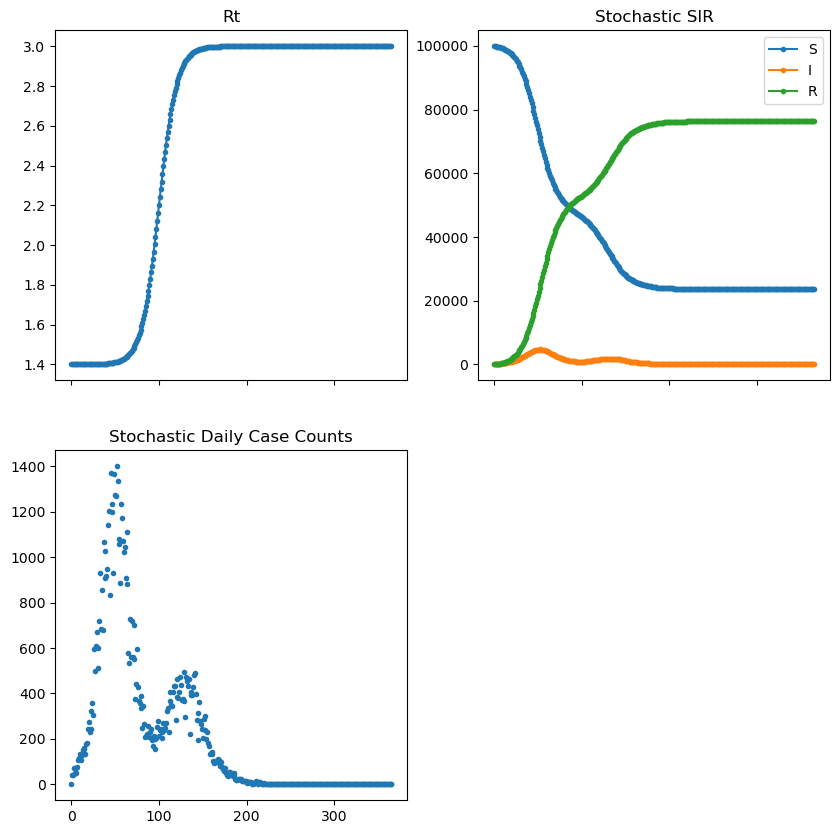

In [58]:
true_params = {
    'rt_0': 1.4,
    'rt_1': 3.,
    'midpoint': 100.,
    'k': 0.1,
    'n_t': 365,
    't_I': 4.,
    'N': 100_000.,
    'S0': 99_900.,
    'I0': 100.,
}


np.random.seed(1994)

# data = simulate_data.simulate_data(**true_params, run_deterministic=True)

data = simulate_data.simulate_data(**true_params, add_noise=True, noise_param=1/50)

data.plot_all()

# Ensemble Adjustment Kalman Filter

\begin{align*}
    \text{Dynamics Model:}\quad & v_{j+1}^{(n)} = \Psi(v_j^{(n)}) + \xi_j^{(n)} \\
    \text{Data Model:}\quad & y_{j+1}^{(n)} = H v_{j+1}^{(n)} + \eta_{j+1}^{(n)} \\
    & x_0^{(n)} \perp \{\xi_j^{(n)}\} \perp \{\eta_j^{(n)}\}
\end{align*}

### Algorithm 1. (EAKF)

1: **Input:** Ensemble size $N$. Initial ensemble $\left\{x_0^{(n)}\right\}_{n=1}^N$.

2: For $j=0,1, \ldots, J-1$ do the following prediction and analysis steps:
    
3: **Prediction:**
$$
\begin{aligned}
\xi_j^{(n)} & \sim \mathcal{N}(0, \Sigma), \quad \text { i.i.d., } \quad n=1, \ldots, N \\
\widehat{v}_{j+1}^{(n)} & =\Psi\left(v_j^{(n)}\right)+ \color{red}{\xi_j^{(n)}}, \quad n=1, \ldots, N \\
\widehat{m}_{j+1} & =\frac{1}{N} \sum_{n=1}^N \widehat{v}_{j+1}^{(n)}, \\
\widehat{C}_{j+1} & =\frac{1}{N} \sum_{n=1}^N\left(\widehat{v}_{j+1}^{(n)}-\widehat{m}_{j+1}\right) \otimes\left(\widehat{v}_{j+1}^{(n)}-\widehat{m}_{j+1}\right) .
\end{aligned}
$$

4: **Analysis:**
$$
\begin{aligned}
& \eta_{j+1}^{(n)} \sim \mathcal{N}(0, \Gamma), \quad n=1, \ldots, N, \\
& y_{j+1}^{(n)}=y_{j+1}+ \eta_{j+1}^{(n)}, \quad n=1, \ldots, N \\
& v_{j+1}^{(n)}=\left(I-K_{j+1} H\right) \widehat{v}_{j+1}^{(n)}+K_{j+1} y_{j+1}^{(n)}, \quad n=1, \ldots, N .
\end{aligned}
$$

5: **Output:** Ensembles $\left\{v_j^{(n)}\right\}_{n=1}^N, \quad j=0,1, \ldots, J$




Given an observational error variance (OEV),

$$\sigma^2_{post}= \sigma^2_{prior}\frac{oev}{\sigma^2_{prior}+oev}$$
$$\mu_{post}= \sigma^2_{post}\left(\frac{\mu_{prior}}{\sigma^2_{prior}} + \frac{c_t}{oev}\right)$$

In [59]:
import collections

SIR = collections.namedtuple(
  typename='SIRComponents',
  field_names=[
    'S',              # S
    'I',               # I
    'R',                # R
    'i'])

ModelParams = collections.namedtuple(
    typename='ModelParams',
    field_names=[
      'beta',                        # Beta
      't_I'   # t_I = 1/gamma
    ]
)

In [60]:
beta = data.construct_beta(data.rt, data.t_I)

x = SIR(
    S = data.S0,
    I = data.I0,
    R = 0,
    i = 0
)
θ = ModelParams(beta, data.t_I)

In [61]:
def f(t, x, θ, N, dt=1, noise_param=1/25):
    """
    State transition function.
        Args:
            t: time
            x: state space
            θ: parameters
            N: population
            dt: time step in days
    """

    # Stochastic transitions
    dSI = np.random.poisson(x.S * x.I/ N * θ.beta) # susceptible to infected
    dIR = np.random.poisson(x.I / θ.t_I) # infected to recovered
    
    # OEV = np.maximum(1., dSI**2 * noise_param)
    # OEV_sample= np.random.normal(0, 1, size=len(dSI))
    # i_noise = dSI + OEV_sample * np.sqrt(OEV)

    # Updates
    x_new = SIR(
        S = np.clip(x.S - dSI, 0, N),
        I = np.clip(x.I + dSI - dIR, 0, N),
        R = np.clip(x.R + dIR, 0, N),
        i = np.clip(dSI, 0, N)
    )

    return x_new

def g(x, α):
    """
    Observational function.
        Args:
            x: state space
            α: report rate
    """
    # y = np.random.binomial(x.i.astype(int), α)
    return x.i

def f0(pop, m=300):
    """
    Initial guess of the state space.
        Args:
            pop: population
            m: number of ensemble members
    """
#     I0 = pop * inf_init
#     S0 = pop - I0
#     R0 = 0
#     i = 0

    S0 = np.random.uniform(pop*0.8, pop, size=m)
    I0 = pop - S0
    R0 = np.zeros(m)
    i0 = np.zeros(m)
    
    x0 = SIR(
        S = S0,
        I = I0,
        R = R0,
        i = i0
    )
    return x0

def θ0(prior, m=300):
    """
    Initial guess of the parameter space.
        Args:
            prior: prior
            m: number of ensemble members
    """
    beta = prior['beta']['dist'](**prior['beta']['args'], size=m)
    θ0 = ModelParams(beta=beta, t_I=np.ones(m)*data.t_I)
    return θ0

In [62]:
def eakf(x, y, z, oev):
    """
    Args:
        x: latenet state rv or latent parameter rv
        y: observed rv
        z: observation
        oev: observational error variance
    """
    x = np.array(x)
    y = np.array(y)
    
    p, m = x.shape

    mu_prior  = y.mean()
    var_prior = y.var()

    # degenerate prior.
    var_prior = np.where(var_prior == 0., 1e-3, var_prior)

    var_post = var_prior * oev / (var_prior + oev)
    mu_post  = var_post  * (mu_prior/var_prior + z/oev)
    alpha    = (oev / (oev + var_prior)) ** (0.5)
    dy       = (mu_post - y) + alpha * (y - mu_prior)
    
    # compute covariance
    rr = np.full((p, 1), np.nan)

    # import pdb; pdb.set_trace()
    for ip in range(p):
        A  = np.cov(x[ip, :], y)
        rr[ip,:] =  A[1, 0] / var_prior
    dx = np.dot(rr, dy.reshape((1,300)))
    # rr = np.cov(x, y)[:-1,-1] / var_prior
    # dx_new = np.dot(rr.reshape((4,1)), dy.reshape((1,300)))

    xpost = x + dx
    ypost = y + dy

    return xpost, ypost

In [63]:
from numpy.random import uniform

prior = {
    'beta':{
        'dist': uniform,
        'args':{
            'low': 0.1,
            'high': 2.,
        }
    },
    't_I':{
        'dist': "constant",
        # 'args':{
        #     'lower': 1.,
        #     'upper': 12.,
        # }
    },
}



## Run filter entire time series to learn $\beta(t)$

In [64]:
from tqdm import tqdm

x_list = []
θ_list = []

for t, date in enumerate(range(data.n_t)):
    if t == 0:
        x = f0(data.N)
        θ = θ0(prior)
    else:
        x = f(t, x, θ, data.N)  # prediction
        y = g(x, α=1)           # analysis
        z = data.i[t]
        
        # noise_param = 1/100
        # oev = np.random.normal(0, 1) * np.maximum(1., z * noise_param)
        oev = np.maximum(10, z**2/50)
        x, new_i = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = x._replace(i=new_i)
        x = SIR(
            S = np.clip(x.S, 0, data.N),
            I = np.clip(x.I, 0, data.N),
            R = np.clip(x.R, 0, data.N),
            i = np.clip(x.i, 0, data.N)
        )
        θ, _ = eakf(θ, y, z, oev=oev)
        θ = np.clip(θ, 0, None)
        θ = ModelParams(*θ)
    
    x_list.append(x)
    θ_list.append(θ)

In [65]:
# df = pd.DataFrame(np.append(np.array([x.i for x in x_list]), np.array([np.arange(0,365)]).T, axis=1), columns = [f"ens_{x}" for x in range(300)] + ["day"])
# df_long = pd.wide_to_long(df, stubnames='ens_', i=['day'], j='num')
# df_long = df_long.reset_index()

# fig = px.line(df_long, x="day", y="ens_", color="num")
# fig.show()

In [66]:
# import plotly.graph_objects as go

# trace1 = go.Scatter(x=df['day'][:2],
#                     y=df['ens_0'][:2],
#                     mode='lines',
#                     line=dict(width=1.5))
# frames = [dict(data= [dict(type='scatter',
#                            x=df['day'][:k+1],
#                            y=df['ens_0'][:k+1]),
#                      ],
#                traces= [0],  
#               )for k  in  range(1, len(df)-1)]
# layout = go.Layout(width=700,
#                    height=600,
#                    showlegend=False,
#                    hovermode='x unified',
#                    updatemenus=[
#                         dict(
#                             type='buttons', showactive=False,
#                             y=1.05,
#                             x=1.15,
#                             xanchor='right',
#                             yanchor='top',
#                             pad=dict(t=0, r=10),
#                             buttons=[dict(label='Play',
#                             method='animate',
#                             args=[None, 
#                                   dict(frame=dict(duration=10, 
#                                                   redraw=False),
#                                                   transition=dict(duration=0),
#                                                   fromcurrent=True,
#                                                   mode='immediate')]
#                             )]
#                         ),
#                         dict(
#                             type = "buttons",
#                             direction = "left",
#                             buttons=list([
#                                 dict(
#                                     args=[{"yaxis.type": "linear"}],
#                                     label="LINEAR",
#                                     method="relayout"
#                                 ),
#                                 dict(
#                                     args=[{"yaxis.type": "log"}],
#                                     label="LOG",
#                                     method="relayout"
#                                 )
#                             ]),
#                         ),
#                     ]              
#                   )
# layout.update(xaxis =dict(range=[0, 365], autorange=False),
#               yaxis =dict(range=[0, 2000], autorange=False));
# fig = go.Figure(data=[trace1], frames=frames, layout=layout)
# fig.show()

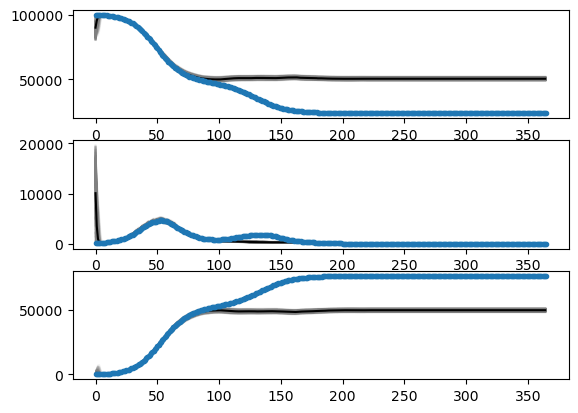

In [67]:
fig, ax = plt.subplots(3)
ax[0].plot([x.S for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.S for x in x_list], axis=1), color='black')
ax[0].plot(data.S, '.')

ax[1].plot([x.I for x in x_list], color='gray', alpha=0.1)
ax[1].plot(np.mean([x.I for x in x_list], axis=1), color='black')
ax[1].plot(data.I, '.')

ax[2].plot([x.R for x in x_list], color='gray', alpha=0.1)
ax[2].plot(np.mean([x.R for x in x_list], axis=1), color='black')
ax[2].plot(data.R, '.')

Text(0.5, 0.98, 'EAKF full time series no inflation')

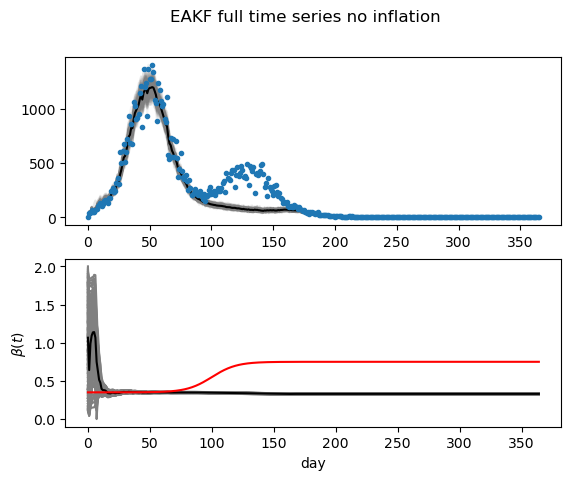

In [68]:
fig, ax = plt.subplots(2)
ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')
ax[0].plot(data.i, '.')

ax[1].plot([θ.beta for θ in θ_list], color="gray")
ax[1].plot(np.mean([θ.beta for θ in θ_list], axis=1), color="black")
ax[1].plot(beta, color="red")
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

fig.suptitle('EAKF full time series no inflation')


### Try adding some inflation

Inflate variance of parameter ensemble by 20% every other day between days 50 and 200. 

In [69]:
def inflate_ensembles(ens, inflation_value=1.2):
    _, m = np.asarray(ens).shape
    ens_mean = np.mean(ens, 1, keepdims=True)
    return ens_mean * np.ones((1,m)) + inflation_value*(ens - ens_mean*np.ones((1,m)))

In [70]:
from tqdm import tqdm

x_list = []
θ_list = []

for t, date in tqdm(enumerate(range(data.n_t))):
    if t == 0:
        x = f0(data.N)
        θ = θ0(prior)
    else:
        if (50 < t) & (t < 200) & (t % 2 == 0):
            # x = SIR(*inflate_ensembles(x, inflation_value=1.2))
            # x = SIR(
            #     S = np.clip(x.S, 0, data.N),
            #     I = np.clip(x.I, 0, data.N),
            #     R = np.clip(x.R, 0, data.N),
            #     i = np.clip(x.i, 0, data.N)
            # )
            θ = inflate_ensembles(θ, inflation_value=1.2)
            θ = np.clip(θ, 0, 10)
            θ = ModelParams(*θ)
            
        x = f(t, x, θ, data.N)  # prediction
        y = g(x, α=1)           # analysis
        z = data.i[t]
        
        oev = np.maximum(10, z**2/50)
        x, new_i = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = x._replace(i=new_i)
        x = SIR(
            S = np.clip(x.S, 0, data.N),
            I = np.clip(x.I, 0, data.N),
            R = np.clip(x.R, 0, data.N),
            i = np.clip(x.i, 0, data.N)
        )
        θ, _ = eakf(θ, y, z, oev=oev)
        θ = np.clip(θ, 0, None)
        θ = ModelParams(*θ)
    
    x_list.append(x)
    θ_list.append(θ)

365it [00:00, 2481.31it/s]


Text(0.5, 0.98, 'EAKF full time series with inflation 20%')

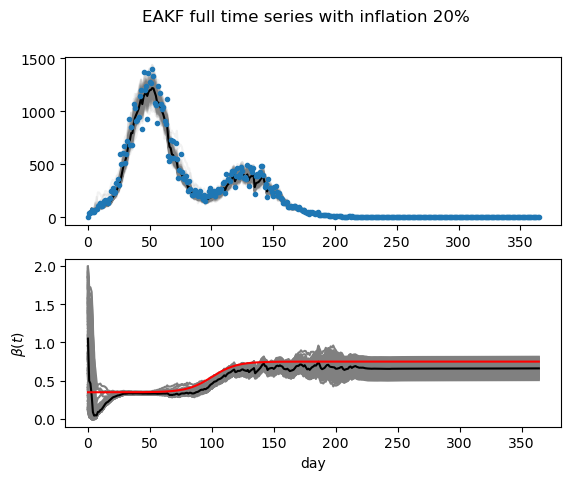

In [71]:
fig, ax = plt.subplots(2)
ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')
ax[0].plot(data.i, '.')

ax[1].plot([θ.beta for θ in θ_list], color="gray")
ax[1].plot(np.mean([θ.beta for θ in θ_list], axis=1), color="black")
ax[1].plot(beta, color="red")
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

fig.suptitle('EAKF full time series with inflation 20%')


In [72]:
betas = np.asarray([θ.beta for θ in θ_list])
I0s = np.asarray(x_list[0].I)

In [73]:
def free_sim(beta, I0):
    S = np.array([data.S0 * np.ones(300)])
    Ir = np.array([data.I0 * np.ones(300)])
    R = np.array([np.zeros(300)])
    i = np.array([np.zeros(300)])
    
    for t in range(data.n_t):
        if t < 20:
            dSI = np.random.poisson(0.35*Ir[t]*S[t]/data.N)
        else:
            dSI = np.random.poisson(beta[t]*Ir[t]*S[t]/data.N)
        dIR = np.random.poisson(Ir[t]/data.t_I)

        S_new = np.clip(S[t]-dSI, 0, data.N)
        I_new = np.clip(Ir[t]+dSI-dIR, 0, data.N)
        R_new = np.clip(R[t]+dIR, 0, data.N)

        S = np.append(S, [S_new], axis=0)
        Ir = np.append(Ir, [I_new], axis=0)
        R = np.append(R, [R_new], axis=0)
        i = np.append(i, [dSI], axis=0)


    return S, Ir, R, i

In [74]:
S, Ir, R, i = free_sim(betas, I0s)

In [75]:
ci = np.quantile(i, q=[0.025, 0.975], axis=1)

In [76]:
ci_50 = np.quantile(i, q=[0.25, 0.75], axis=1)

Text(0.5, 1.0, 'free simulation')

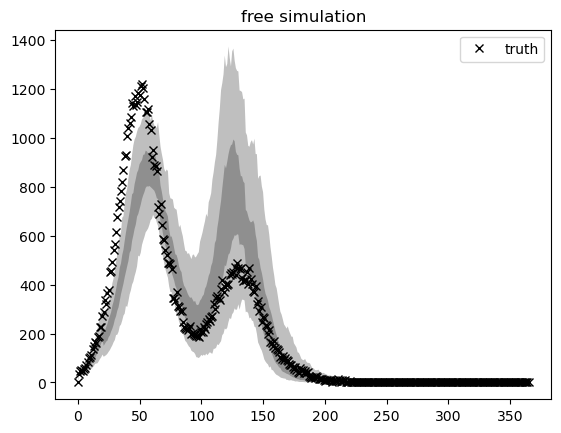

In [77]:
# plt.plot(i, '-.', alpha=0.1, color='grey')
plt.fill_between(np.arange(0,366), ci[0], ci[1], facecolor='gray', alpha=0.5)
plt.fill_between(np.arange(0,366), ci_50[0], ci_50[1], facecolor='gray', alpha=0.75)
plt.plot(data.i_true, 'x', color='black', label="truth")
plt.legend()

plt.title("free simulation")

## Run filter split time series to learn $\beta(t)$

In [78]:
midpoint = 75

In [79]:
from tqdm import tqdm

x_list = []
θ_list = []

for t, date in enumerate(range(midpoint)):
    if t == 0:
        x = f0(data.N)
        θ = θ0(prior)
    else:
        if (50 < t) & (t < 200) & (t % 2 == 0):
            # x = SIR(*inflate_ensembles(x, inflation_value=1.2))
            # x = SIR(
            #     S = np.clip(x.S, 0, data.N),
            #     I = np.clip(x.I, 0, data.N),
            #     R = np.clip(x.R, 0, data.N),
            #     i = np.clip(x.i, 0, data.N)
            # )
            θ = inflate_ensembles(θ, inflation_value=1.2)
            θ = np.clip(θ, 0, 10)
            θ = ModelParams(*θ)
        x = f(t, x, θ, data.N)  # prediction
        y = g(x, α=1)           # analysis
        z = data.i[t]
        
        # noise_param = 1/100
        # oev = np.random.normal(0, 1) * np.maximum(1., z * noise_param)
        oev = np.maximum(10, z**2/50)
        x, new_i = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = x._replace(i=new_i)
        x = SIR(
            S = np.clip(x.S, 0, data.N),
            I = np.clip(x.I, 0, data.N),
            R = np.clip(x.R, 0, data.N),
            i = np.clip(x.i, 0, data.N)
        )
        θ, _ = eakf(θ, y, z, oev=oev)
        θ = np.clip(θ, 0, None)
        θ = ModelParams(*θ)
    
    x_list.append(x)
    θ_list.append(θ)

Text(0.5, 0.98, 'EAKF first half time series inflation 20%')

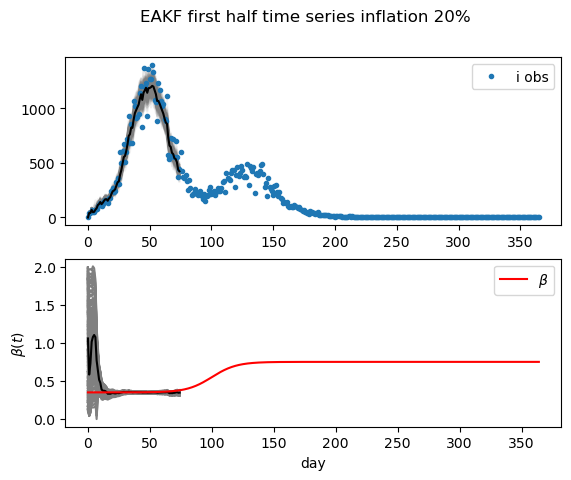

In [80]:
fig, ax = plt.subplots(2)
ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
ax[0].plot(data.i, '.', label="i obs")
ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')
ax[0].legend()

ax[1].plot([θ.beta for θ in θ_list], color="gray")
ax[1].plot(np.mean([θ.beta for θ in θ_list], axis=1), color="black")
ax[1].plot(beta, color="red", label=r"$\beta$")
ax[1].legend()
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

fig.suptitle('EAKF first half time series inflation 20%')


In [81]:
from tqdm import tqdm

x_list_2 = []
θ_list_2 = []

for t in range(midpoint, data.n_t):
    if t == midpoint:
        # x = x_list[-1]
        # x = inflate_ensembles(np.asarray(x))
        # x = SIR(*x)
        # θ = θ_list[-1]
        # θ = inflate_ensembles(np.asarray(θ))
        # θ = ModelParams(*θ)
        x = SIR(
            S = data.S[midpoint] + np.random.normal(0,10,300),
            I = data.I[midpoint] + np.random.normal(0,10,300),
            R = data.R[midpoint] + np.random.normal(0,10,300),
            i = data.i[midpoint] + np.random.normal(0,10,300)
        )
        θ = θ0(prior)
    else:
        if (50 < t) & (t < 200) & (t % 2 == 0):
            # x = SIR(*inflate_ensembles(x, inflation_value=1.2))
            # x = SIR(
            #     S = np.clip(x.S, 0, data.N),
            #     I = np.clip(x.I, 0, data.N),
            #     R = np.clip(x.R, 0, data.N),
            #     i = np.clip(x.i, 0, data.N)
            # )
            θ = inflate_ensembles(θ, inflation_value=1.2)
            θ = np.clip(θ, 0, 10)
            θ = ModelParams(*θ)
        x = f(t, x, θ, data.N)  # prediction
        y = g(x, α=1)           # analysis
        z = data.i[t]
        
        oev = np.maximum(10, z**2/50)
        x, new_i = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = x._replace(i=new_i)
        x = SIR(
            S = np.clip(x.S, 0, data.N),
            I = np.clip(x.I, 0, data.N),
            R = np.clip(x.R, 0, data.N),
            i = np.clip(x.i, 0, data.N)
        )
        θ, _ = eakf(θ, y, z, oev=oev)
        θ = np.clip(θ, 0, None)
        θ = ModelParams(*θ)
    x_list_2.append(x)
    θ_list_2.append(θ)

Text(0.5, 0.98, 'EAKF second half time series inflation 20%')

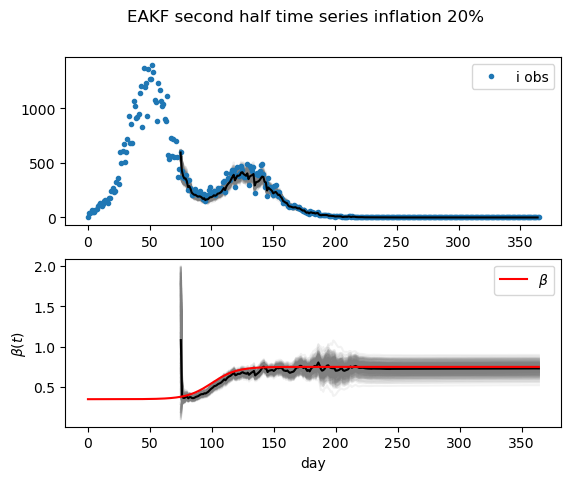

In [82]:
fig, ax = plt.subplots(2)
ax[0].plot(np.arange(midpoint, data.n_t), [x.i for x in x_list_2], color='gray', alpha=0.1)
ax[0].plot(data.i, '.', label="i obs")
ax[0].plot(np.arange(midpoint, data.n_t), np.mean([x.i for x in x_list_2], axis=1), color='black')
ax[0].legend()

ax[1].plot(np.arange(midpoint, data.n_t), [θ.beta for θ in θ_list_2], color="gray", alpha=0.1)
ax[1].plot(np.arange(midpoint, data.n_t), np.mean([θ.beta for θ in θ_list_2], axis=1), color="black")
ax[1].plot(beta, color="red", label=r"$\beta$")
ax[1].legend()
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

fig.suptitle('EAKF second half time series inflation 20%')


array([[1.90274975, 0.57893655, 0.72941096, ..., 1.56524048, 0.46238001,
        1.0112598 ],
       [0.70620846, 0.20945696, 0.40565636, ..., 1.1683979 , 0.12813284,
        0.81907385],
       [0.8705232 , 0.39435509, 0.63947031, ..., 1.29554146, 0.26859506,
        0.96825375],
       ...,
       [0.36684492, 0.33686321, 0.35610183, ..., 0.35261753, 0.35173274,
        0.36954795],
       [0.3597948 , 0.33125279, 0.34873179, ..., 0.34632726, 0.34552245,
        0.36185798],
       [0.36373078, 0.33134285, 0.35006861, ..., 0.34820226, 0.34850159,
        0.36536319]])

Text(0.5, 1.0, 'free simulation')

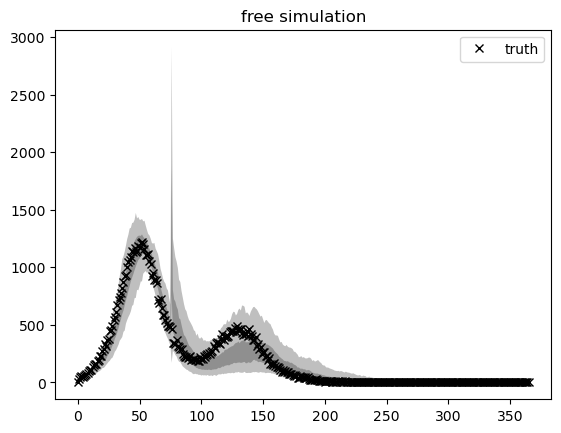

In [89]:
betas1 = np.array([θ.beta for θ in θ_list])[:midpoint]
betas2 = np.array([θ.beta for θ in θ_list_2])
betas = np.append(betas1, betas2, axis=0)
I0s = np.asarray(x_list[0].I)

S, Ir, R, i = free_sim(betas, I0s)

ci = np.quantile(i, q=[0.025, 0.975], axis=1)

ci_50 = np.quantile(i, q=[0.25, 0.75], axis=1)

# plt.plot(i, '-.', alpha=0.1, color='grey')
plt.fill_between(np.arange(0,366), ci[0], ci[1], facecolor='gray', alpha=0.5)
plt.fill_between(np.arange(0,366), ci_50[0], ci_50[1], facecolor='gray', alpha=0.75)
plt.plot(data.i_true, 'x', color='black', label="truth")
plt.legend()

plt.title("free simulation")

## Infer sigmoid parameters

In [90]:
SigmoidModelParams = collections.namedtuple(
    typename='SigmoidModelParams',
    field_names=[
        'beta_0',
        'beta_1',
        'midpoint',
        'k'
    ]
)

In [91]:
def clip_states(x):
    return SIR(
            S = np.clip(x.S, 0, data.N),
            I = np.clip(x.I, 0, data.N),
            R = np.clip(x.R, 0, data.N),
            i = np.clip(x.i, 0, data.N)
        )

def clip_sigmoid_params(θ):
    return SigmoidModelParams(
        beta_0 = np.clip(θ.beta_0, 0, None),
        beta_1 = np.clip(θ.beta_1, 0, None),
        midpoint = np.clip(θ.midpoint, 0, 365),
        k = np.clip(θ.k, 0, None),
    )

In [92]:
prior = {
    'beta_0':{
        'dist': uniform,
        'args':{
            'low': 0.1,
            'high': 2.,
        }
    },
    'beta_1':{
        'dist': uniform,
        'args':{
            'low': 0.5,
            'high': 2.5,
        }
    },
    'midpoint':{
        'dist': uniform,
        'args':{
            'low': 30,
            'high': 200,
        }
    },
    'k':{
        'dist': uniform,
        'args':{
            'low': 0.01,
            'high': 2.,
        }
    },
    'logk':{
        'dist': uniform,
        'args':{
            'low':-2,
            'high':0.3,
        }
    }
}

In [93]:
def θ0(prior, m=300):
    """
    Initial guess of the parameter space.
        Args:
            prior: prior
            m: number of ensemble members
    """
    beta_0 = prior['beta_0']['dist'](**prior['beta_0']['args'], size=m)
    beta_1 = prior['beta_1']['dist'](**prior['beta_1']['args'], size=m)
    k = prior['k']['dist'](**prior['k']['args'], size=m)
    midpoint = prior['midpoint']['dist'](**prior['midpoint']['args'], size=m)
    
    θ0 = SigmoidModelParams(
        beta_0 = beta_0,
        beta_1 = beta_1,
        midpoint = midpoint,
        k = k,
    )
    return θ0

In [94]:
def f(t, x, θ, N, dt=1, noise_param=1/25):
    """
    State transition function.
        Args:
            t: time
            x: state space
            θ: parameters
            N: population
            dt: time step in days
    """

    # Stochastic transitions
    beta = θ.beta_0 + (θ.beta_1 - θ.beta_0) / (1 + np.exp(-θ.k*(t - θ.midpoint)))
    dSI = np.random.poisson(x.S * x.I/ N * beta) # susceptible to infected
    dIR = np.random.poisson(x.I / data.t_I) # infected to recovered
    
    # OEV = np.maximum(1., dSI**2 * noise_param)
    # OEV_sample= np.random.normal(0, 1, size=len(dSI))
    # i_noise = dSI + OEV_sample * np.sqrt(OEV)

    # Updates
    x_new = SIR(
        S = np.clip(x.S - dSI, 0, N),
        I = np.clip(x.I + dSI - dIR, 0, N),
        R = np.clip(x.R + dIR, 0, N),
        i = np.clip(dSI, 0, N)
    )

    return x_new

In [95]:
x_list = []
θ_list = []
for t, date in enumerate(range(data.n_t)):
    if t == 0:
        x = f0(data.N)
        θ = θ0(prior)
    else:
        x = f(t, x, θ, data.N)  # prediction
        y = g(x, α=1)           # analysis
        z = data.i[t]
        
        # noise_param = 1/100
        # oev = np.random.normal(0, 1) * np.maximum(1., z * noise_param)
        oev = np.maximum(10, z**2/50)
        x, new_i = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = clip_states(x)
        x = x._replace(i=new_i)
        θ, _ = eakf(θ, y, z, oev=oev)
        θ = np.clip(θ, 0, None)
        θ = SigmoidModelParams(*θ)
    
    x_list.append(x)
    θ_list.append(θ)

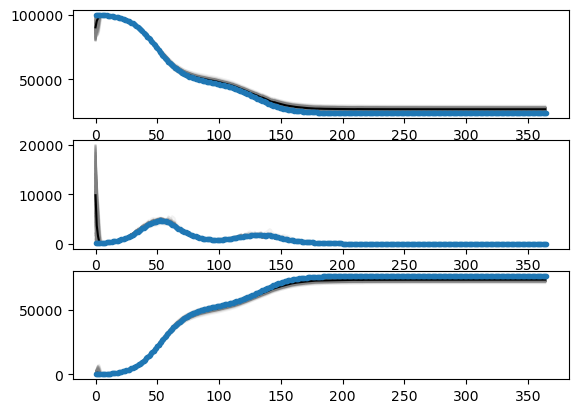

In [96]:
fig, ax = plt.subplots(3)
ax[0].plot([x.S for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.S for x in x_list], axis=1), color='black')
ax[0].plot(data.S, '.')

ax[1].plot([x.I for x in x_list], color='gray', alpha=0.1)
ax[1].plot(np.mean([x.I for x in x_list], axis=1), color='black')
ax[1].plot(data.I, '.')

ax[2].plot([x.R for x in x_list], color='gray', alpha=0.1)
ax[2].plot(np.mean([x.R for x in x_list], axis=1), color='black')
ax[2].plot(data.R, '.')

In [97]:
post = θ_list[-1]
t = np.arange(0, data.n_t)
sigmoid = [post.beta_0 + (post.beta_1 - post.beta_0) / (1 + np.exp(-post.k*(tt - post.midpoint))) for tt in t]

Text(0, 0.5, '$\\beta(t)$')

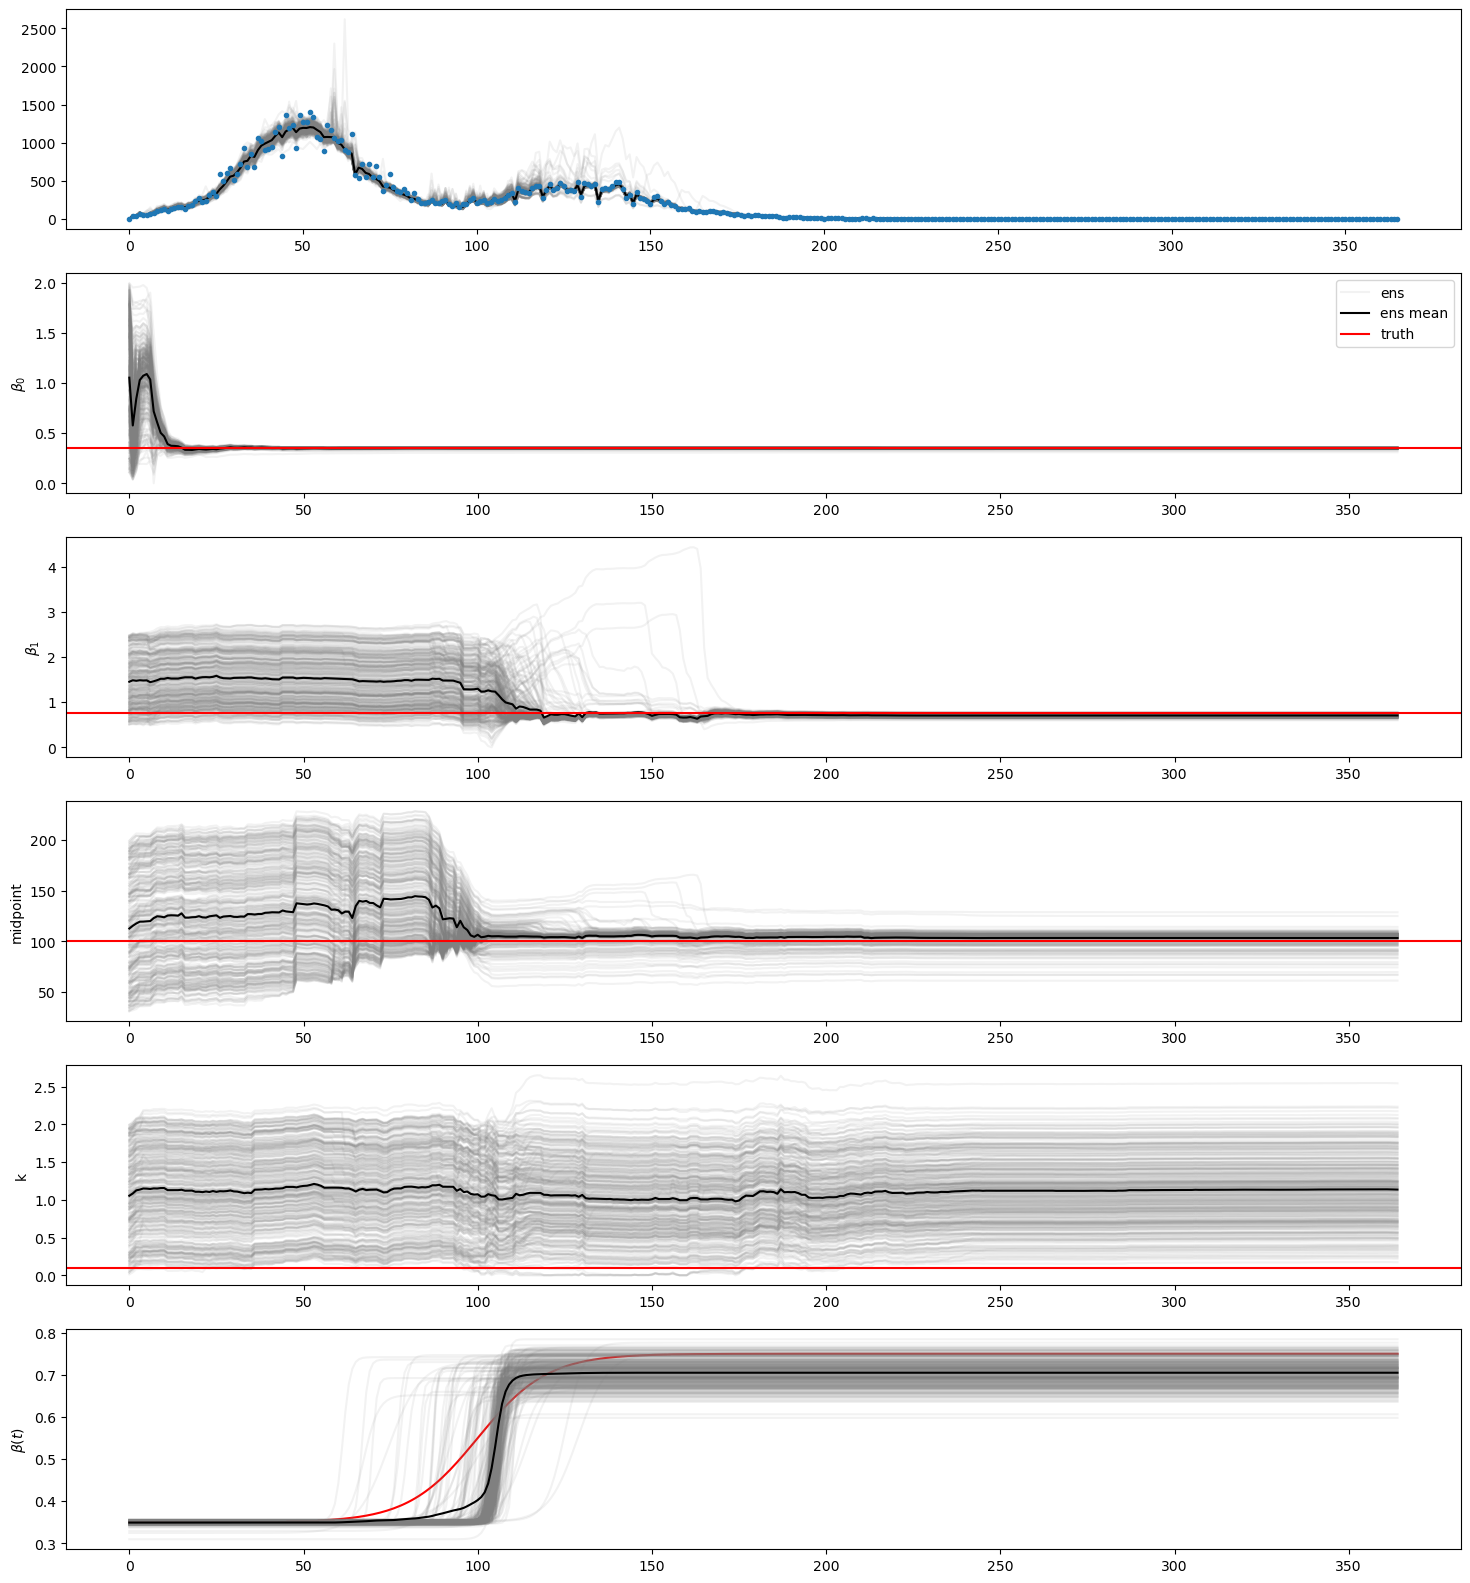

In [98]:
fig, ax = plt.subplots(6, figsize=(18,20))
ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')
ax[0].plot(data.i, '.')

ax[1].plot([θ.beta_0 for θ in θ_list], color="gray", alpha=0.1)
ax[1].plot([],[], 'gray', alpha=0.1, label='ens')
ax[1].plot(np.mean([θ.beta_0 for θ in θ_list], axis=1), color='black', label="ens mean")
ax[1].axhline(beta[0], color="red", label="truth")
ax[1].set_ylabel(r"$\beta_0$")
ax[1].legend()

ax[2].plot([θ.beta_1 for θ in θ_list], color="gray", alpha=0.1)
ax[2].plot(np.mean([θ.beta_1 for θ in θ_list], axis=1), color='black')
ax[2].axhline(beta[-1], color="red")
ax[2].set_ylabel(r"$\beta_1$")

ax[3].plot([θ.midpoint for θ in θ_list], color="gray", alpha=0.1)
ax[3].plot(np.mean([θ.midpoint for θ in θ_list], axis=1), color='black')
ax[3].axhline(data.midpoint, color="red")
ax[3].set_ylabel(r"midpoint")

ax[4].plot([θ.k for θ in θ_list], color="gray", alpha=0.1)
ax[4].plot(np.mean([θ.k for θ in θ_list], axis=1), color='black')
ax[4].axhline(data.k, color="red")
ax[4].set_ylabel(r"k")

ax[5].plot(beta, color="red")
ax[5].plot(sigmoid, color="gray", alpha=0.1)
ax[5].plot(np.mean(sigmoid, axis=1), color="black")
ax[5].set_ylabel(r"$\beta(t)$")



In [99]:
θ_sigma = np.std(θ_list[-1], axis=1)
θ_mu = np.mean(θ_list[-1], axis=1)

In [100]:
pd.DataFrame(np.vstack([np.mean(np.asarray(θ_list[-1]), axis=1),
                        np.quantile(np.asarray(θ_list[-1]), q=(0.025, 0.975), axis=1),
                        np.array([beta[0], beta[-1], data.midpoint, data.k])
                       ]).T,
             columns=["mean", "lower", "upper", "truth"]
            )

,mean,lower,upper,truth
0,0.349190,0.342681,0.355047,0.350018
1,0.705086,0.647615,0.760259,0.750000
2,103.314885,81.394786,110.023332,100.000000
3,1.135417,0.321854,2.021666,0.100000


In [101]:
def plot_reliability(θ_list):
    post_θ = np.asarray(θ_list)[-1,:,:]

    m,n = post_θ.shape
    nsample = 1000
    idx = np.random.randint(0,m,nsample)
    out = post_θ[:,idx]
    
    post_pred = []
    for theta in out.T:
        post_pred.append(simulate_data.simulate_data(rt_0=theta[0]*data.t_I, rt_1=theta[1]*data.t_I, midpoint=theta[2], k=np.exp(theta[3]), n_t = data.n_t, t_I = data.t_I, N = data.N, S0 = data.S0, I0 = data.I0, add_noise=True, noise_param=1/50).i)
        
        
    post_pred = np.asarray(post_pred)
    lower = np.quantile(post_pred, q = [0.025, 0.975], axis=0)[0,:]
    upper = np.quantile(post_pred, q = [0.025, 0.975], axis=0)[1,:]
    
    lower_50 = np.quantile(post_pred, q = [0.25, 0.75], axis=0)[0,:]
    upper_50 = np.quantile(post_pred, q = [0.25, 0.75], axis=0)[1,:]
    
    fig, ax = plt.subplots(1)

    ax.plot(data.i, '.')
    ax.plot(np.arange(0,366), np.mean(post_pred, axis=0), label='post mean', color='black', ls='--')
    ax.fill_between(np.arange(0,366), lower, upper, facecolor='gray', alpha=0.5,
                    label='95% CI')
    ax.fill_between(np.arange(0,366), lower_50, upper_50, facecolor='gray', alpha=0.95,
                    label='50% CI')
    ax.legend(loc='upper left')
    
    prop_95 = np.mean((lower <= data.i) & (data.i <= upper))
    prop_50 = np.mean((lower_50 <= data.i) & (data.i <= upper_50))

    print(f"Percent of observations in 95% CI {round(prop_95*100, 2)}%")
    print(f"Percent of observations in 50% CI {round(prop_50*100, 2)}%")
    
    prop_list = []
    for p in range(5,100,5):
        lower = np.quantile(post_pred, q = [(1-p/100)/2, 1-(1-p/100)/2], axis=0)[0,:]
        upper = np.quantile(post_pred, q = [(1-p/100)/2, 1-(1-p/100)/2], axis=0)[1,:]
        prop_list.append(np.mean((lower <= data.i) & (data.i <= upper)))
    
    fig, ax = plt.subplots(1)
    ax.plot(np.arange(5,100,5)/100, prop_list)
    ax.axline((0, 0), (1, 1), color='r')
    ax.set_xlabel('CI')
    ax.set_ylabel('% of obs within CI')

/Users/hwunrow/Documents/GitHub/rt-estimation/src/simulate_data.py:50: RuntimeWarning: overflow encountered in exp
  sigmoid = rt_0 + (rt_1 - rt_0) / (1 + np.exp(-k*(t - midpoint)))


Percent of observations in 95% CI 97.81%
Percent of observations in 50% CI 73.5%


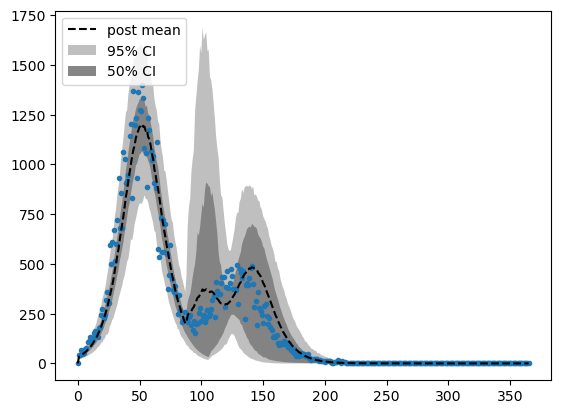

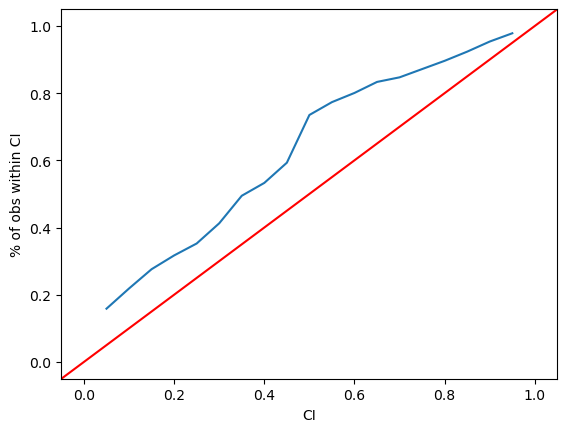

In [102]:
plot_reliability(θ_list)

In [103]:
diff = np.asarray([x.i for x in x_list]).T - data.i_true[:-1]
np.sqrt(np.mean((diff)**2))

39.65802494685965

### Do log(k)

In [104]:
def θ0_logk(prior, m=300):
    """
    Initial guess of the parameter space.
        Args:
            prior: prior
            m: number of ensemble members
    """
    beta_0 = prior['beta_0']['dist'](**prior['beta_0']['args'], size=m)
    beta_1 = prior['beta_1']['dist'](**prior['beta_1']['args'], size=m)
    logk = prior['logk']['dist'](**prior['logk']['args'], size=m)
    midpoint = prior['midpoint']['dist'](**prior['midpoint']['args'], size=m)
    
    θ0 = SigmoidModelParams(
        beta_0 = beta_0,
        beta_1 = beta_1,
        midpoint = midpoint,
        k = logk,
    )
    return θ0

def f_logk(t, x, θ, N, dt=1, noise_param=1/25):
    """
    State transition function.
        Args:
            t: time
            x: state space
            θ: parameters
            N: population
            dt: time step in days
    """

    # Stochastic transitions
    beta = θ.beta_0 + (θ.beta_1 - θ.beta_0) / (1 + np.exp(-np.exp(θ.k)*(t - θ.midpoint)))
    dSI = np.random.poisson(x.S * x.I/ N * beta) # susceptible to infected
    dIR = np.random.poisson(x.I / data.t_I) # infected to recovered
    
    # OEV = np.maximum(1., dSI**2 * noise_param)
    # OEV_sample= np.random.normal(0, 1, size=len(dSI))
    # i_noise = dSI + OEV_sample * np.sqrt(OEV)

    # Updates
    x_new = SIR(
        S = np.clip(x.S - dSI, 0, N),
        I = np.clip(x.I + dSI - dIR, 0, N),
        R = np.clip(x.R + dIR, 0, N),
        i = np.clip(dSI, 0, N)
    )

    return x_new

In [105]:
x_list = []
θ_list = []
for t, date in enumerate(range(data.n_t)):
    if t == 0:
        x = f0(data.N)
        θ = θ0_logk(prior)
    else:
        x = f_logk(t, x, θ, data.N)  # prediction
        y = g(x, α=1)           # analysis
        z = data.i[t]
        
        # noise_param = 1/100
        # oev = np.random.normal(0, 1) * np.maximum(1., z * noise_param)
        oev = np.maximum(10, z**2/50)
        x, new_i = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = clip_states(x)
        x = x._replace(i=new_i)
        θ, _ = eakf(θ, y, z, oev=oev)
        θ_clip = SigmoidModelParams(*np.clip(θ.copy(), 0, None))
        θ = SigmoidModelParams(
            beta_0 = θ_clip.beta_0,
            beta_1 = θ_clip.beta_1,
            midpoint = θ_clip.midpoint,
            k = θ[-1,:]
        )
    
    x_list.append(x)
    θ_list.append(θ)

Text(0, 0.5, '$\\beta(t)$')

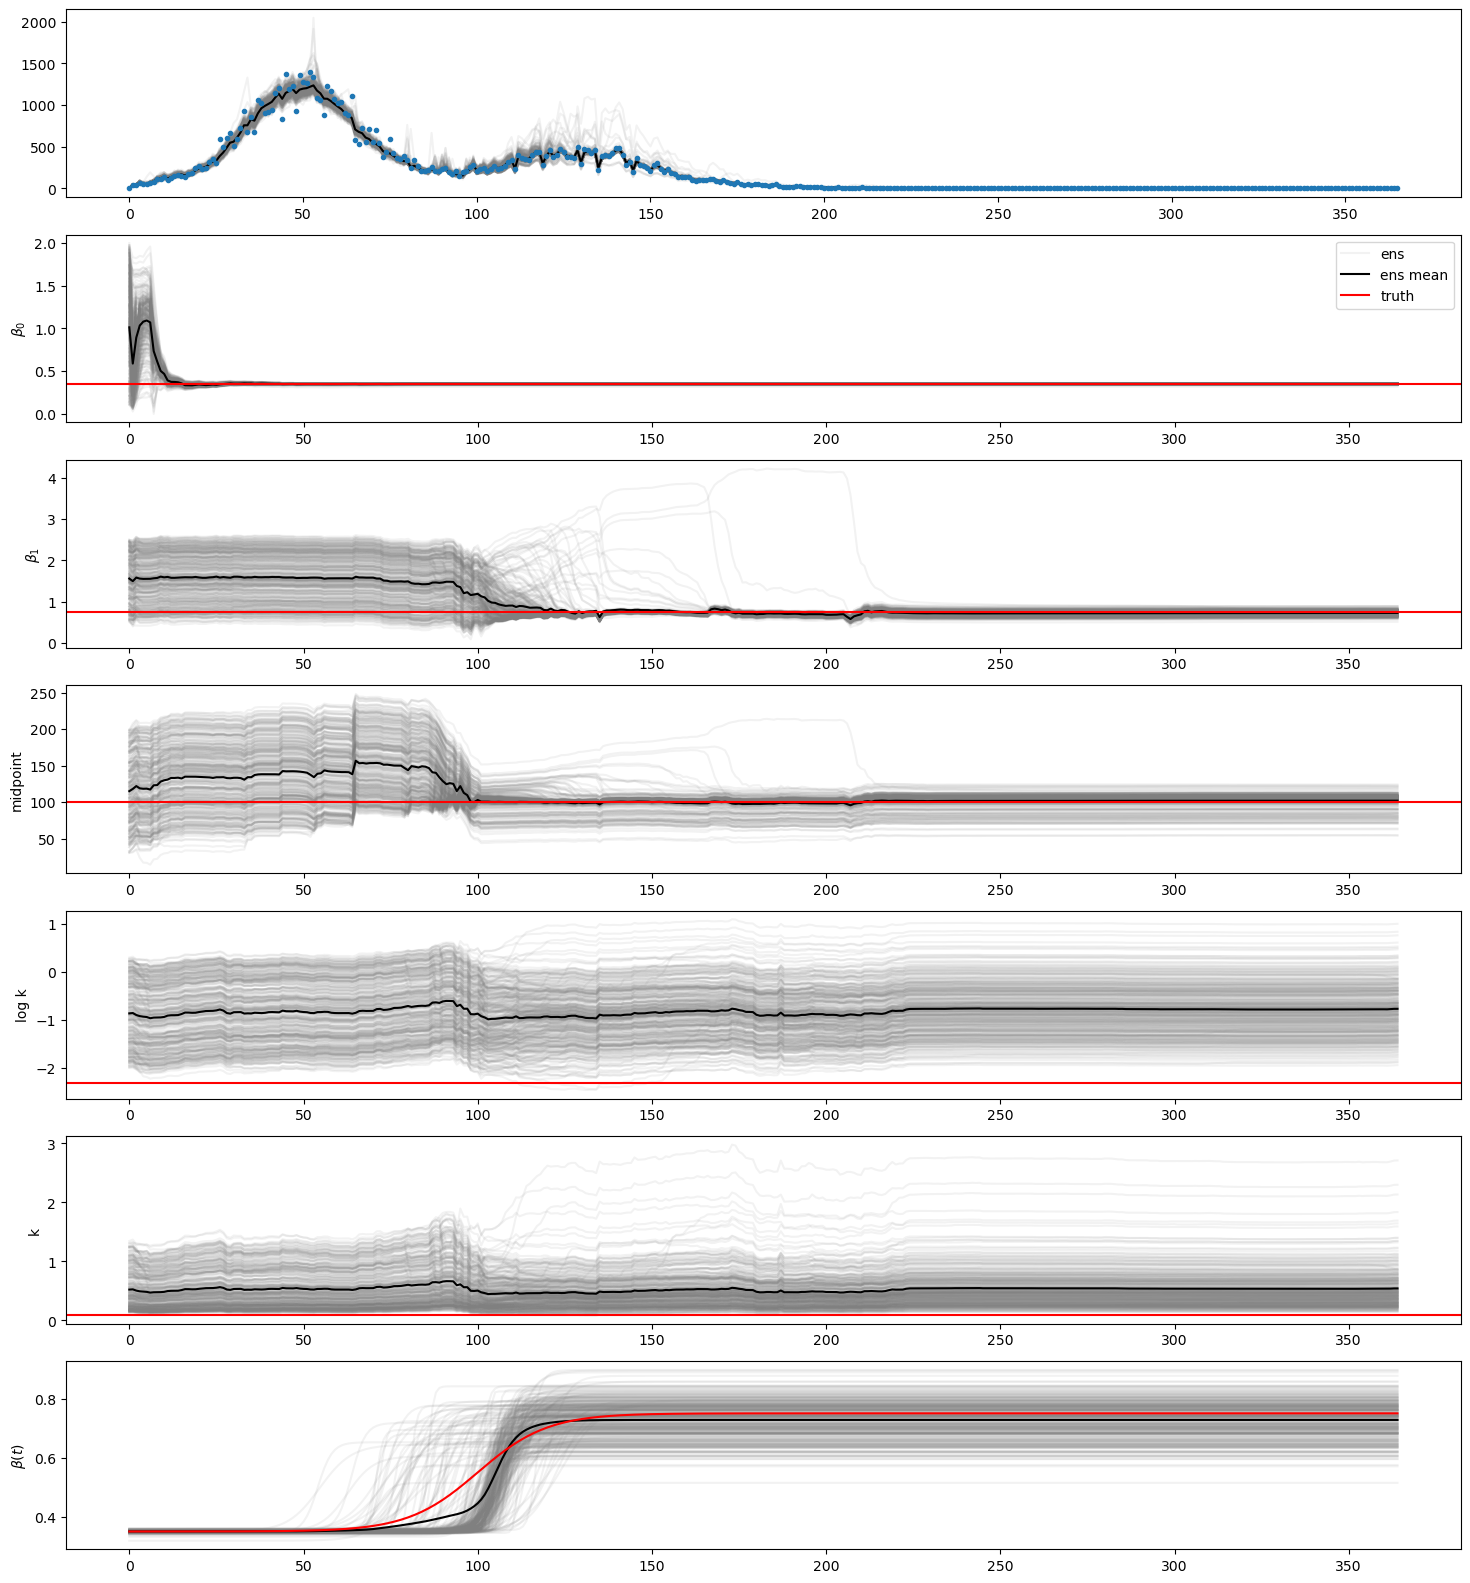

In [106]:
fig, ax = plt.subplots(7, figsize=(18,20))
ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')
ax[0].plot(data.i, '.')

ax[1].plot([θ.beta_0 for θ in θ_list], color="gray", alpha=0.1)
ax[1].plot([],[], 'gray', alpha=0.1, label='ens')
ax[1].plot(np.mean([θ.beta_0 for θ in θ_list], axis=1), color='black', label="ens mean")
ax[1].axhline(beta[0], color="red", label="truth")
ax[1].set_ylabel(r"$\beta_0$")
ax[1].legend()

ax[2].plot([θ.beta_1 for θ in θ_list], color="gray", alpha=0.1)
ax[2].plot(np.mean([θ.beta_1 for θ in θ_list], axis=1), color='black')
ax[2].axhline(beta[-1], color="red")
ax[2].set_ylabel(r"$\beta_1$")

ax[3].plot([θ.midpoint for θ in θ_list], color="gray", alpha=0.1)
ax[3].plot(np.mean([θ.midpoint for θ in θ_list], axis=1), color='black')
ax[3].axhline(data.midpoint, color="red")
ax[3].set_ylabel(r"midpoint")

ax[4].plot([θ.k for θ in θ_list], color="gray", alpha=0.1)
ax[4].plot(np.mean([θ.k for θ in θ_list], axis=1), color='black')
ax[4].axhline(np.log(data.k), color="red")
ax[4].set_ylabel(r"log k")

ax[5].plot([np.exp(θ.k) for θ in θ_list], color="gray", alpha=0.1)
ax[5].plot(np.mean([np.exp(θ.k) for θ in θ_list], axis=1), color='black')
ax[5].axhline(data.k, color="red")
ax[5].set_ylabel(r"k")


post = θ_list[-1]
t = np.arange(0, data.n_t)
sigmoid = [post.beta_0 + (post.beta_1 - post.beta_0) / (1 + np.exp(-np.exp(post.k)*(tt - post.midpoint))) for tt in t]

ax[6].plot(sigmoid, color="gray", alpha=0.1)
ax[6].plot(np.mean(sigmoid, axis=1), color="black")
ax[6].plot(beta, color="red")
ax[6].set_ylabel(r"$\beta(t)$")


In [107]:
pd.DataFrame(np.vstack([np.mean(np.asarray(θ_list[-1]), axis=1),
                        np.quantile(np.asarray(θ_list[-1]), q=(0.025, 0.975), axis=1),
                        np.array([beta[0], beta[-1], data.midpoint, np.log(data.k)])
                       ]).T,
             columns=["mean", "lower", "upper", "truth"]
            )

,mean,lower,upper,truth
0,0.350221,0.342342,0.357144,0.350018
1,0.727748,0.605178,0.842162,0.750000
2,101.974458,71.558850,115.708217,100.000000
3,-0.768619,-1.712840,0.336442,-2.302585


In [108]:
diff = np.asarray([x.i for x in x_list]).T - data.i_true[:-1]
np.sqrt(np.mean((diff)**2))

37.45154363373566

#### Reliability plots 

Percent of observations in 95% CI 95.08%
Percent of observations in 50% CI 69.67%


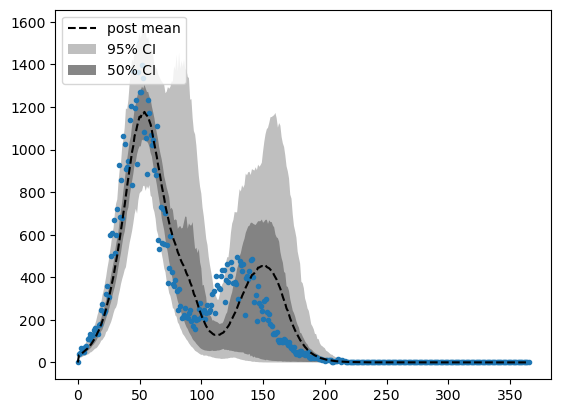

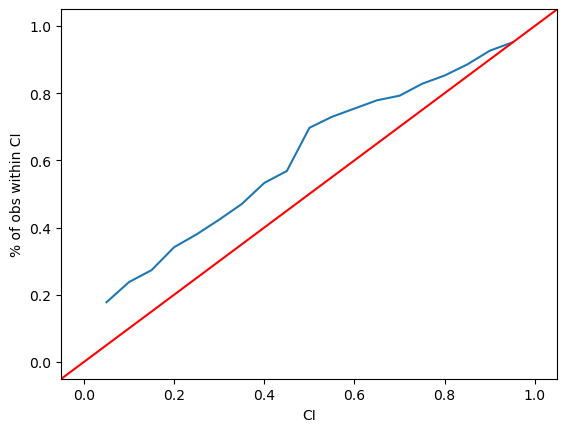

In [109]:
plot_reliability(θ_list)

### Try Iterated Filtering

In [110]:
prior

{'beta_0': {'dist': <function RandomState.uniform>,
  'args': {'low': 0.1, 'high': 2.0}},
 'beta_1': {'dist': <function RandomState.uniform>,
  'args': {'low': 0.5, 'high': 2.5}},
 'midpoint': {'dist': <function RandomState.uniform>,
  'args': {'low': 30, 'high': 200}},
 'k': {'dist': <function RandomState.uniform>,
  'args': {'low': 0.01, 'high': 2.0}},
 'logk': {'dist': <function RandomState.uniform>,
  'args': {'low': -2, 'high': 0.3}}}

Make Sigma larger

In [111]:
Sigma = np.eye(4)
Sigma[0][0] = (2 - 0.1)**2 /12
Sigma[1][1] = (2.5 - 0.5)**2 /12
Sigma[2][2] = (200 - 30)**2 /12
Sigma[3][3] = (2 - 0.01)**2 /12

Sigma

array([[3.00833333e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.33333333e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.40833333e+03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.30008333e-01]])

In [112]:
def sample_if(n, mean, Sigma, a=0.99, m=300):
    θ = np.random.multivariate_normal(mean, a**(2*n)*Sigma, size=m)
    θ = np.clip(θ, 0, None)
    θ = SigmoidModelParams(*θ.T)
    return(θ)

In [113]:
def if_eakf(n_if = 200, avg="all", cooling=0.99):
    if_list = []

    for n in tqdm(range(n_if)):

        if n == 0:
            x = f0(data.N)
            θ = θ0(prior)
        else:
            x = f0(data.N)
            θ = sample_if(n, θ_mean, Sigma, a=cooling)
        x_list = [x]
        θ_list = [θ]
        for t, date in enumerate(range(1, data.n_t)):
            x = f(t, x, θ, data.N)  # prediction
            y = g(x, α=1)           # analysis
            z = data.i[t]

            oev = np.maximum(10, z**2/50)
            x, new_i = eakf(x, y, z, oev=oev)
            x = SIR(*x)
            x = clip_states(x)
            x = x._replace(i=new_i)
            θ, _ = eakf(θ, y, z, oev=oev)
            θ = np.clip(θ, 0, None)
            θ = SigmoidModelParams(*θ)

            x_list.append(x)
            θ_list.append(θ)

        if avg == "all":
            θ_mean = np.mean(np.mean(np.asarray(θ_list), axis=2), axis=0)
        elif avg == "last":
            θ_mean = np.mean(np.asarray(θ_list[-1]), axis=1)
        elif avg == "weighted":
            θ_list_array = np.asarray(θ_list)
            weights = 1/np.var(θ_list_array, axis=2)
            θ_mean = np.asarray([np.mean(np.average(θ_list_array[:,i,:], weights=weights[:,i], axis=0)) for i in range(4)])

        if_list.append(θ_list[0])

    if_list = np.asarray(if_list)
    if_list = np.swapaxes(if_list, 0, 1)

    return x_list, θ_list, if_list

In [114]:
n_if = 200
def plot_if_eakf(x_list, θ_list, if_list, title=f"IF-EAKF with {n_if} iterations (each iteration mean across entire time series)"):
    fig, ax = plt.subplots(6, figsize=(18,20))
    ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
    ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')
    ax[0].plot(data.i, '.')

    ax[1].plot([θ.beta_0 for θ in θ_list], color="gray", alpha=0.1)
    ax[1].plot([],[], 'gray', alpha=0.1, label='ens')
    ax[1].plot(np.mean([θ.beta_0 for θ in θ_list], axis=1), color='black', label="ens mean")
    ax[1].axhline(beta[0], color="red", label="truth")
    ax[1].set_ylabel(r"$\beta_0$")
    ax[1].legend()

    ax[2].plot([θ.beta_1 for θ in θ_list], color="gray", alpha=0.1)
    ax[2].plot(np.mean([θ.beta_1 for θ in θ_list], axis=1), color='black')
    ax[2].axhline(beta[-1], color="red")
    ax[2].set_ylabel(r"$\beta_1$")

    ax[3].plot([θ.midpoint for θ in θ_list], color="gray", alpha=0.1)
    ax[3].plot(np.mean([θ.midpoint for θ in θ_list], axis=1), color='black')
    ax[3].axhline(data.midpoint, color="red")
    ax[3].set_ylabel(r"midpoint")

    ax[4].plot([θ.k for θ in θ_list], color="gray", alpha=0.1)
    ax[4].plot(np.mean([θ.k for θ in θ_list], axis=1), color='black')
    ax[4].axhline(data.k, color="red")
    ax[4].set_ylabel(r"k")

    ax[5].plot(beta, color="red")
    ax[5].set_ylabel(r"$\beta(t)$")

    post = θ_list[-1]
    t = np.arange(0, data.n_t)
    sigmoid = [post.beta_0 + (post.beta_1 - post.beta_0) / (1 + np.exp(-post.k*(tt - post.midpoint))) for tt in t]

    ax[5].plot(sigmoid, color="gray", alpha=0.1)
    ax[5].plot(np.mean(sigmoid, axis=1), color="black")

    fig.suptitle(title)
    
    fig, ax = plt.subplots(4, figsize=(18,20))

    for i in range(4):
        ax[i].plot(if_list[i,:,:], color="gray", alpha=0.1)
        ax[i].plot(np.mean(if_list[i,:,:], axis=1), color="black")

    ax[0].axhline(beta[0], color="red", label="truth")
    ax[0].set_ylabel(r"$\beta_0$")
    ax[1].axhline(beta[-1], color="red", label="truth")
    ax[1].set_ylabel(r"$\beta_1$")
    ax[2].axhline(data.midpoint, color="red", label="truth")
    ax[2].set_ylabel(r"midpoint")
    ax[3].axhline(data.k, color="red")
    ax[3].set_ylabel(r"k")
    ax[3].set_xlabel("iteration")


100%|█████████████████████████████| 200/200 [00:28<00:00,  6.98it/s]


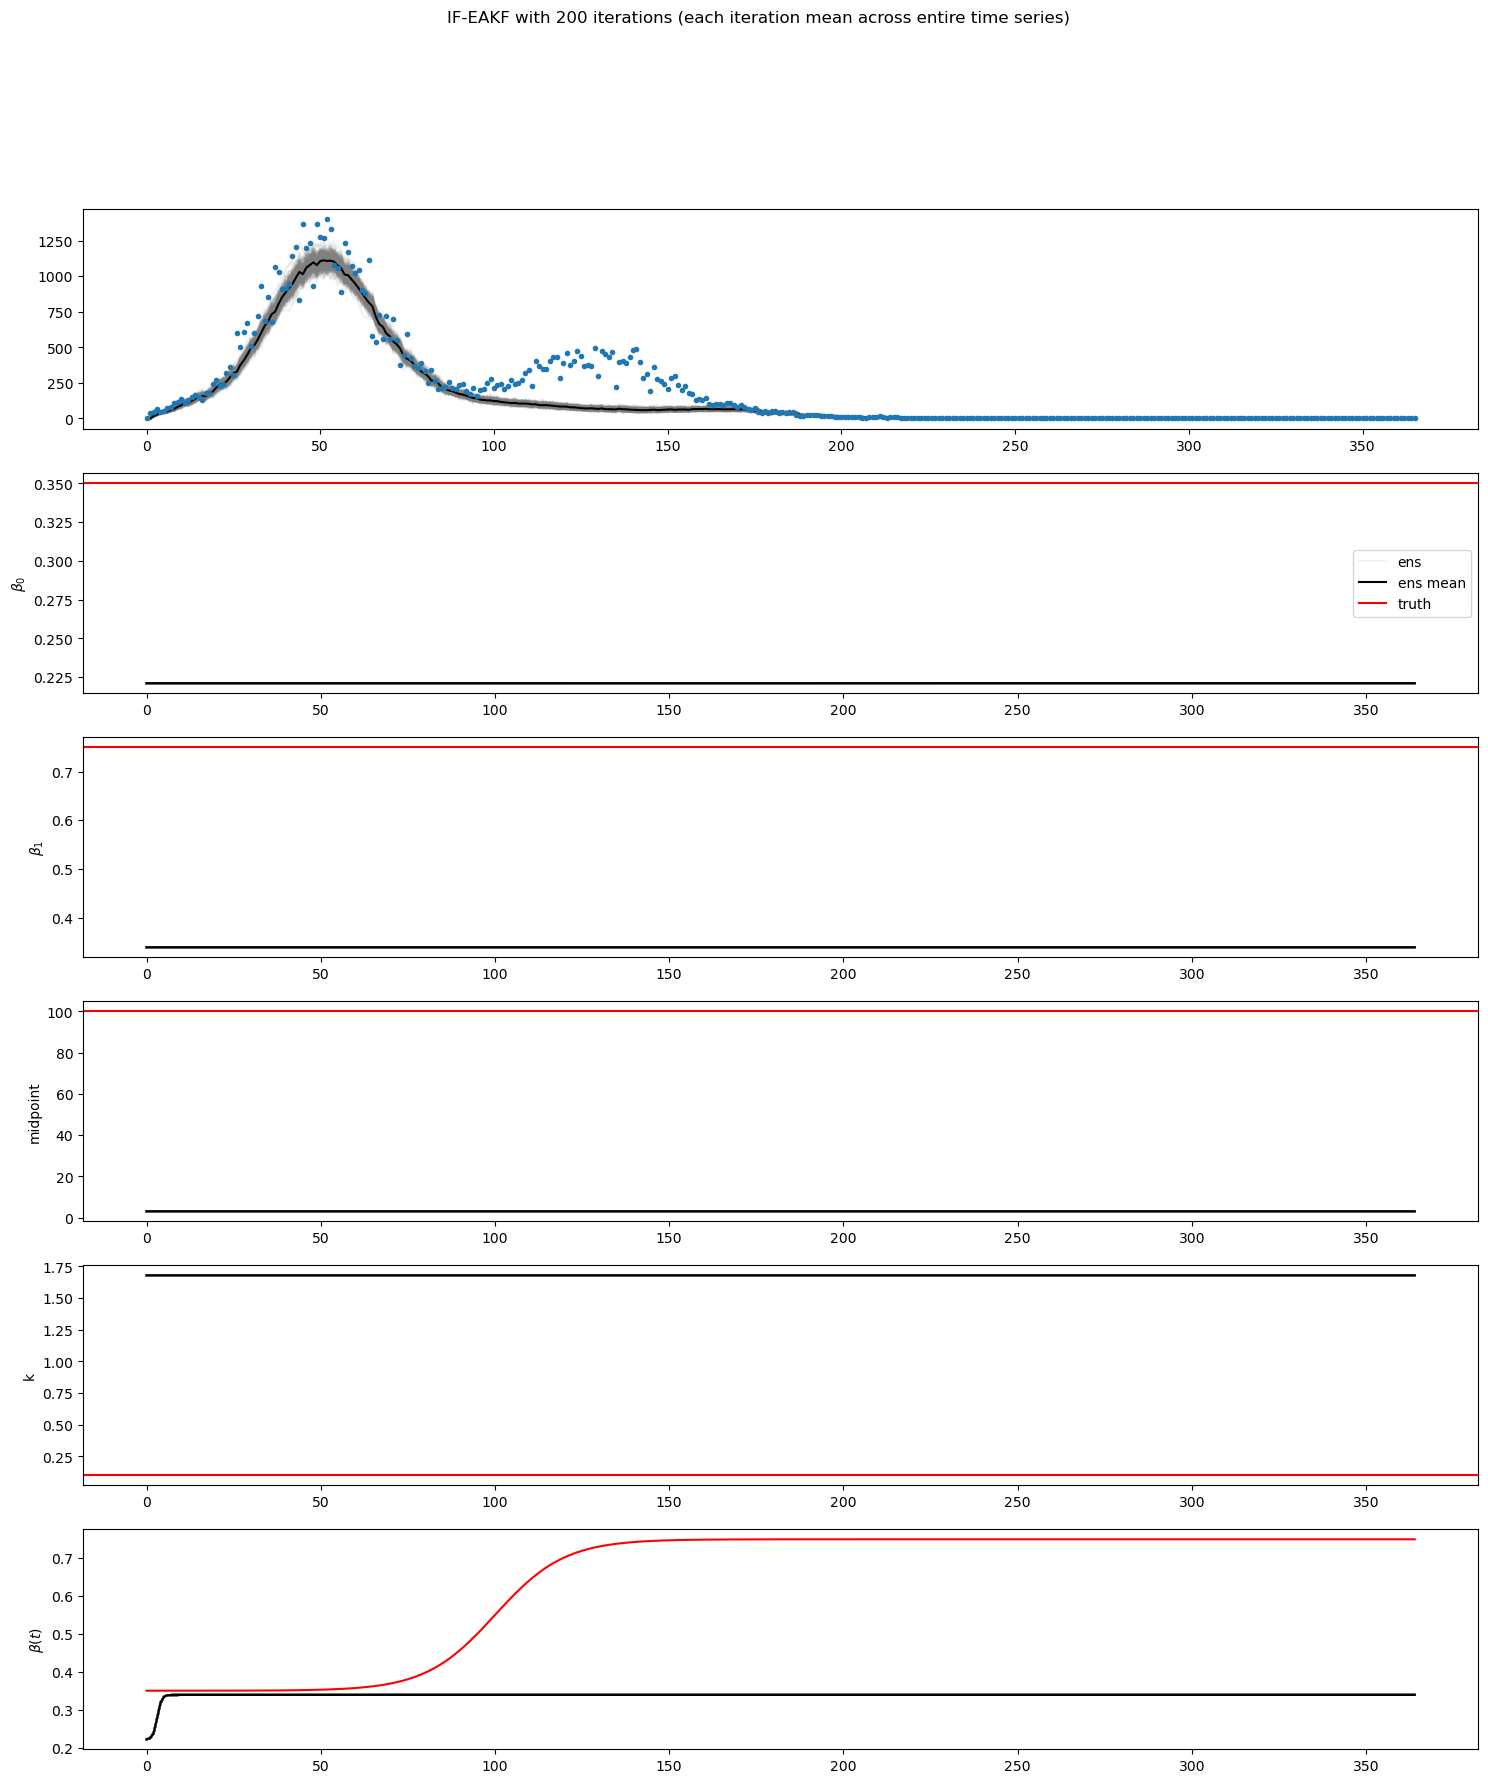

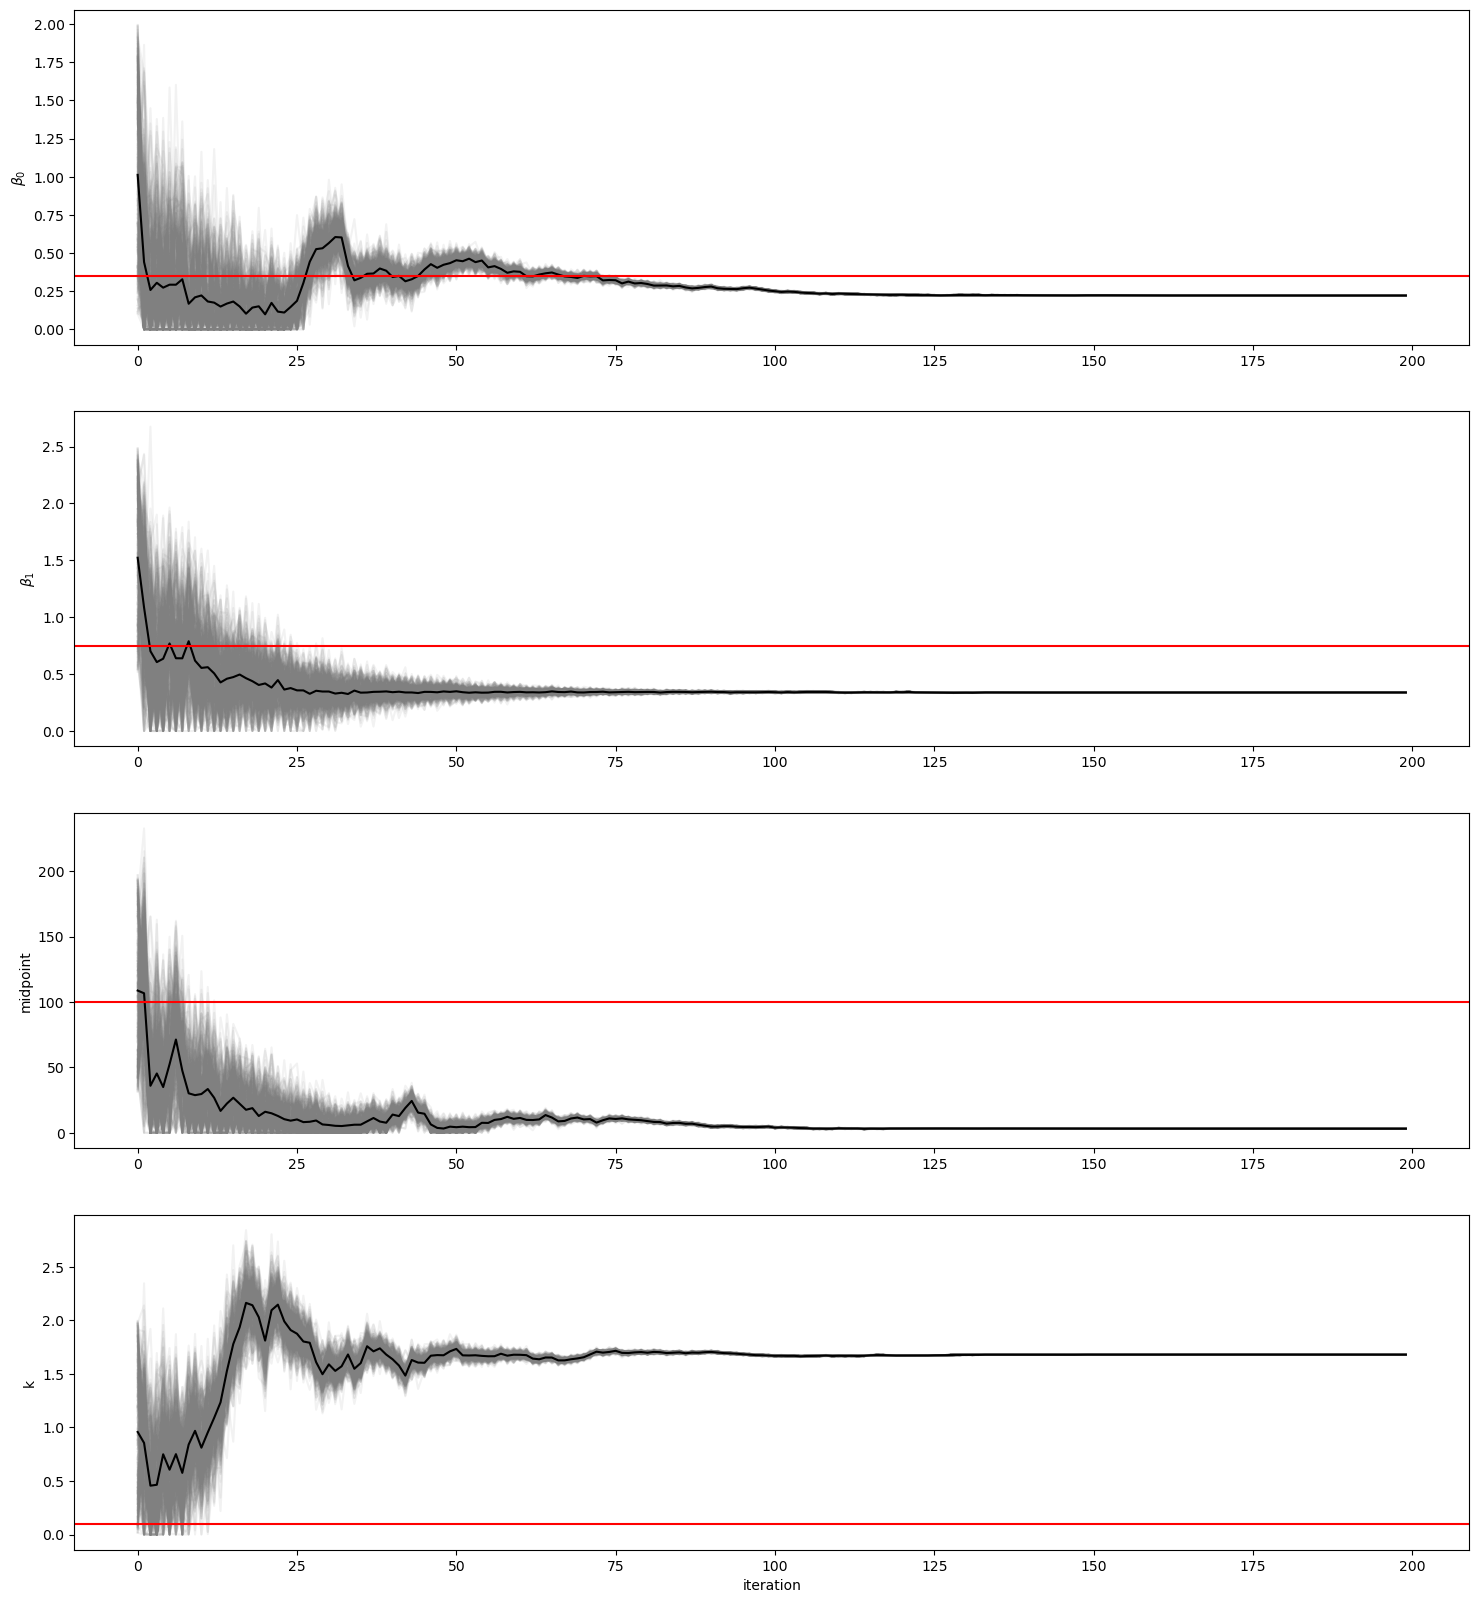

In [115]:
x_list, θ_list, if_list = if_eakf(n_if = 200, avg="all", cooling=0.95)
plot_if_eakf(x_list, θ_list, if_list)

In [116]:
diff = np.asarray([x.i for x in x_list]).T - data.i_true[:-1]
np.sqrt(np.mean((diff)**2))

119.50088354283986

  0%|▏                              | 1/200 [00:00<00:29,  6.80it/s]/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_16385/2112105630.py:13: RuntimeWarning: overflow encountered in exp
  beta = θ.beta_0 + (θ.beta_1 - θ.beta_0) / (1 + np.exp(-θ.k*(t - θ.midpoint)))
100%|█████████████████████████████| 200/200 [00:27<00:00,  7.22it/s]


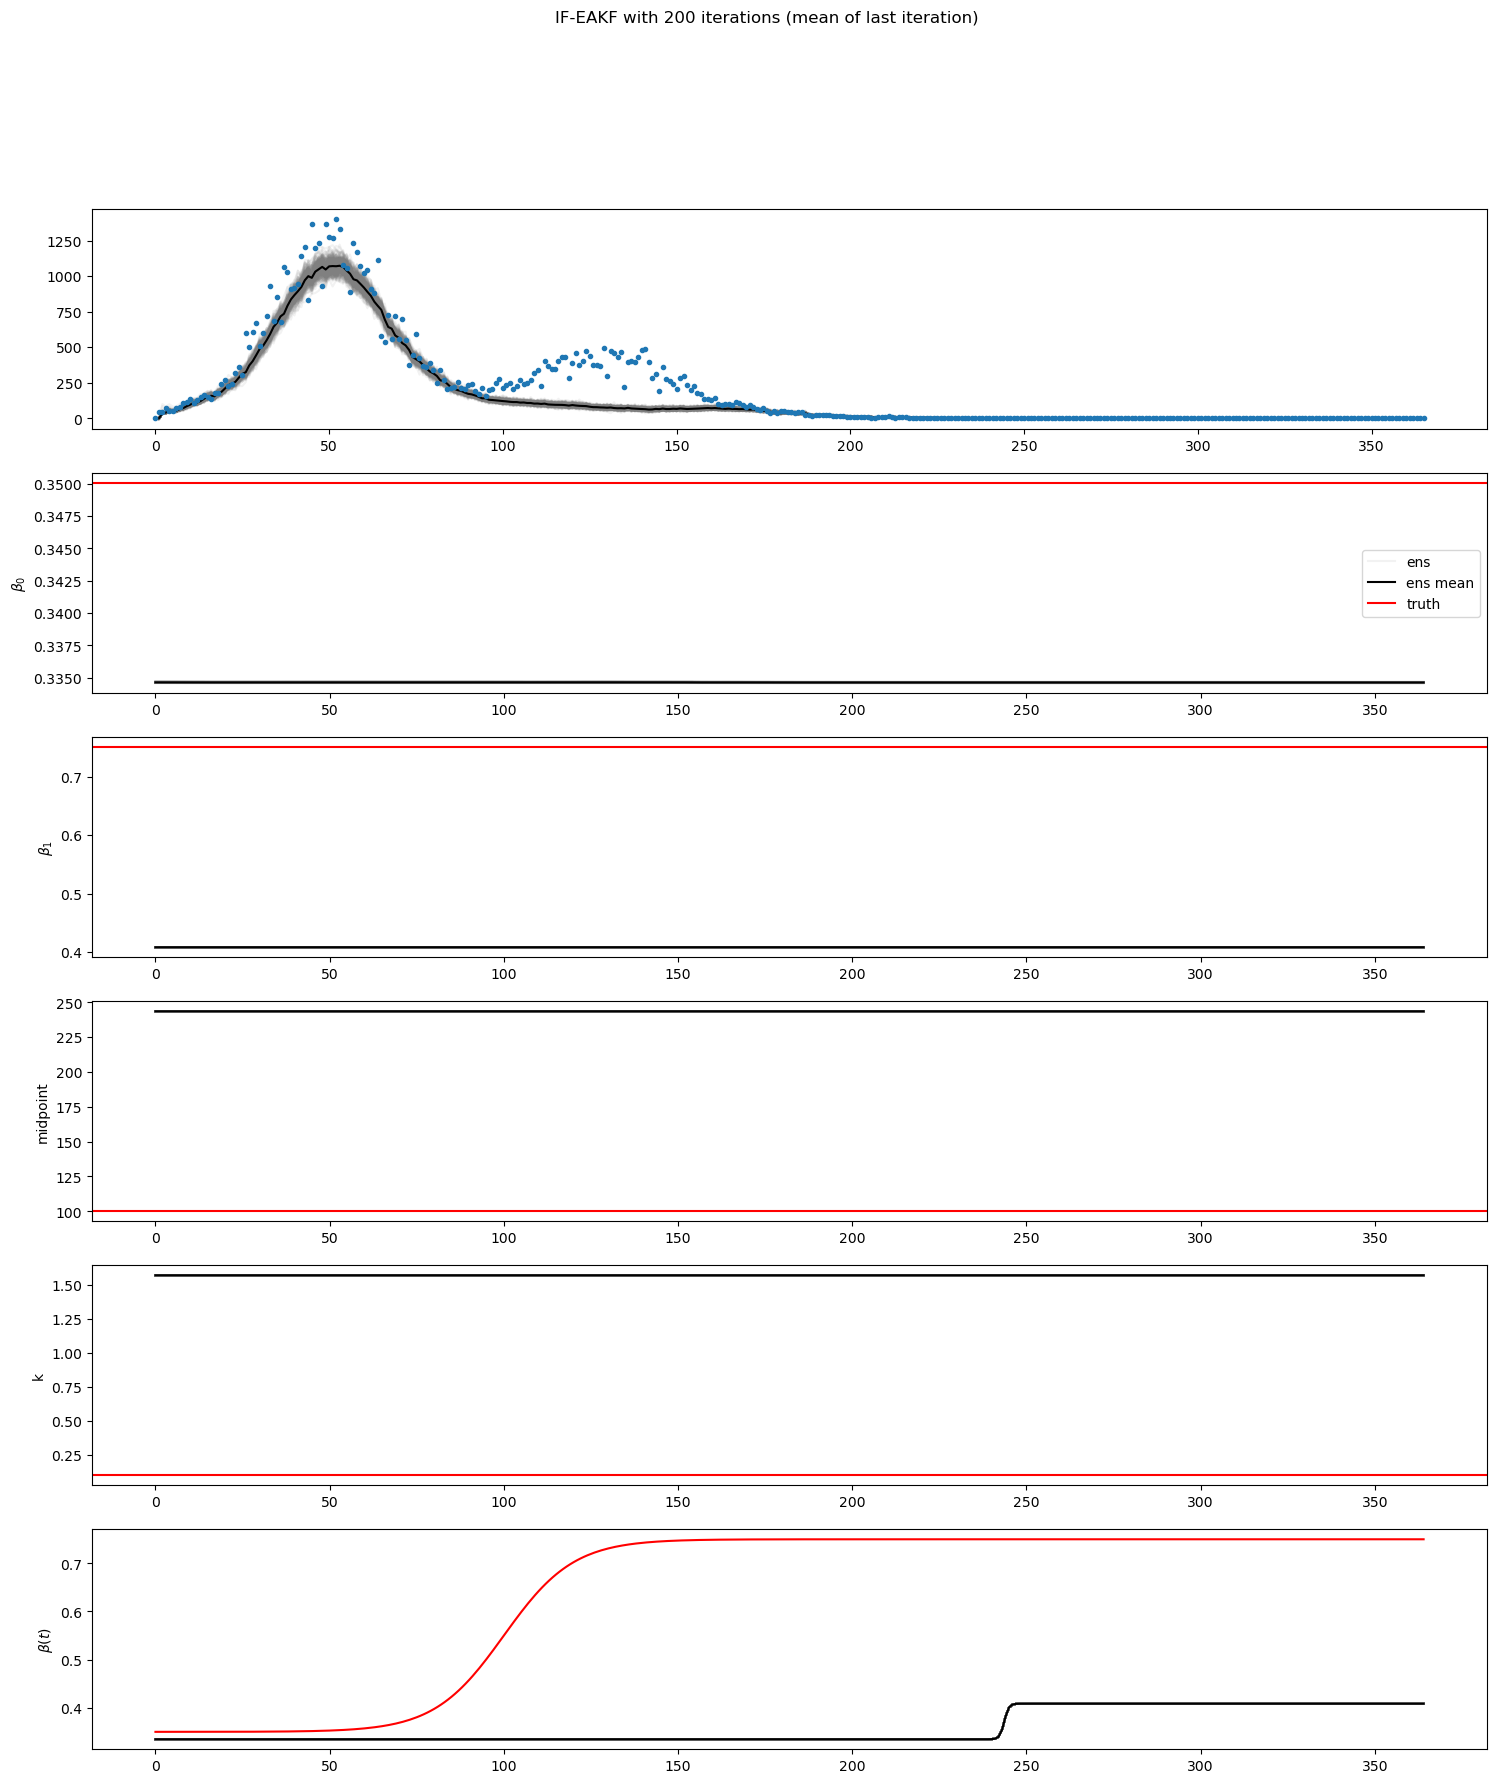

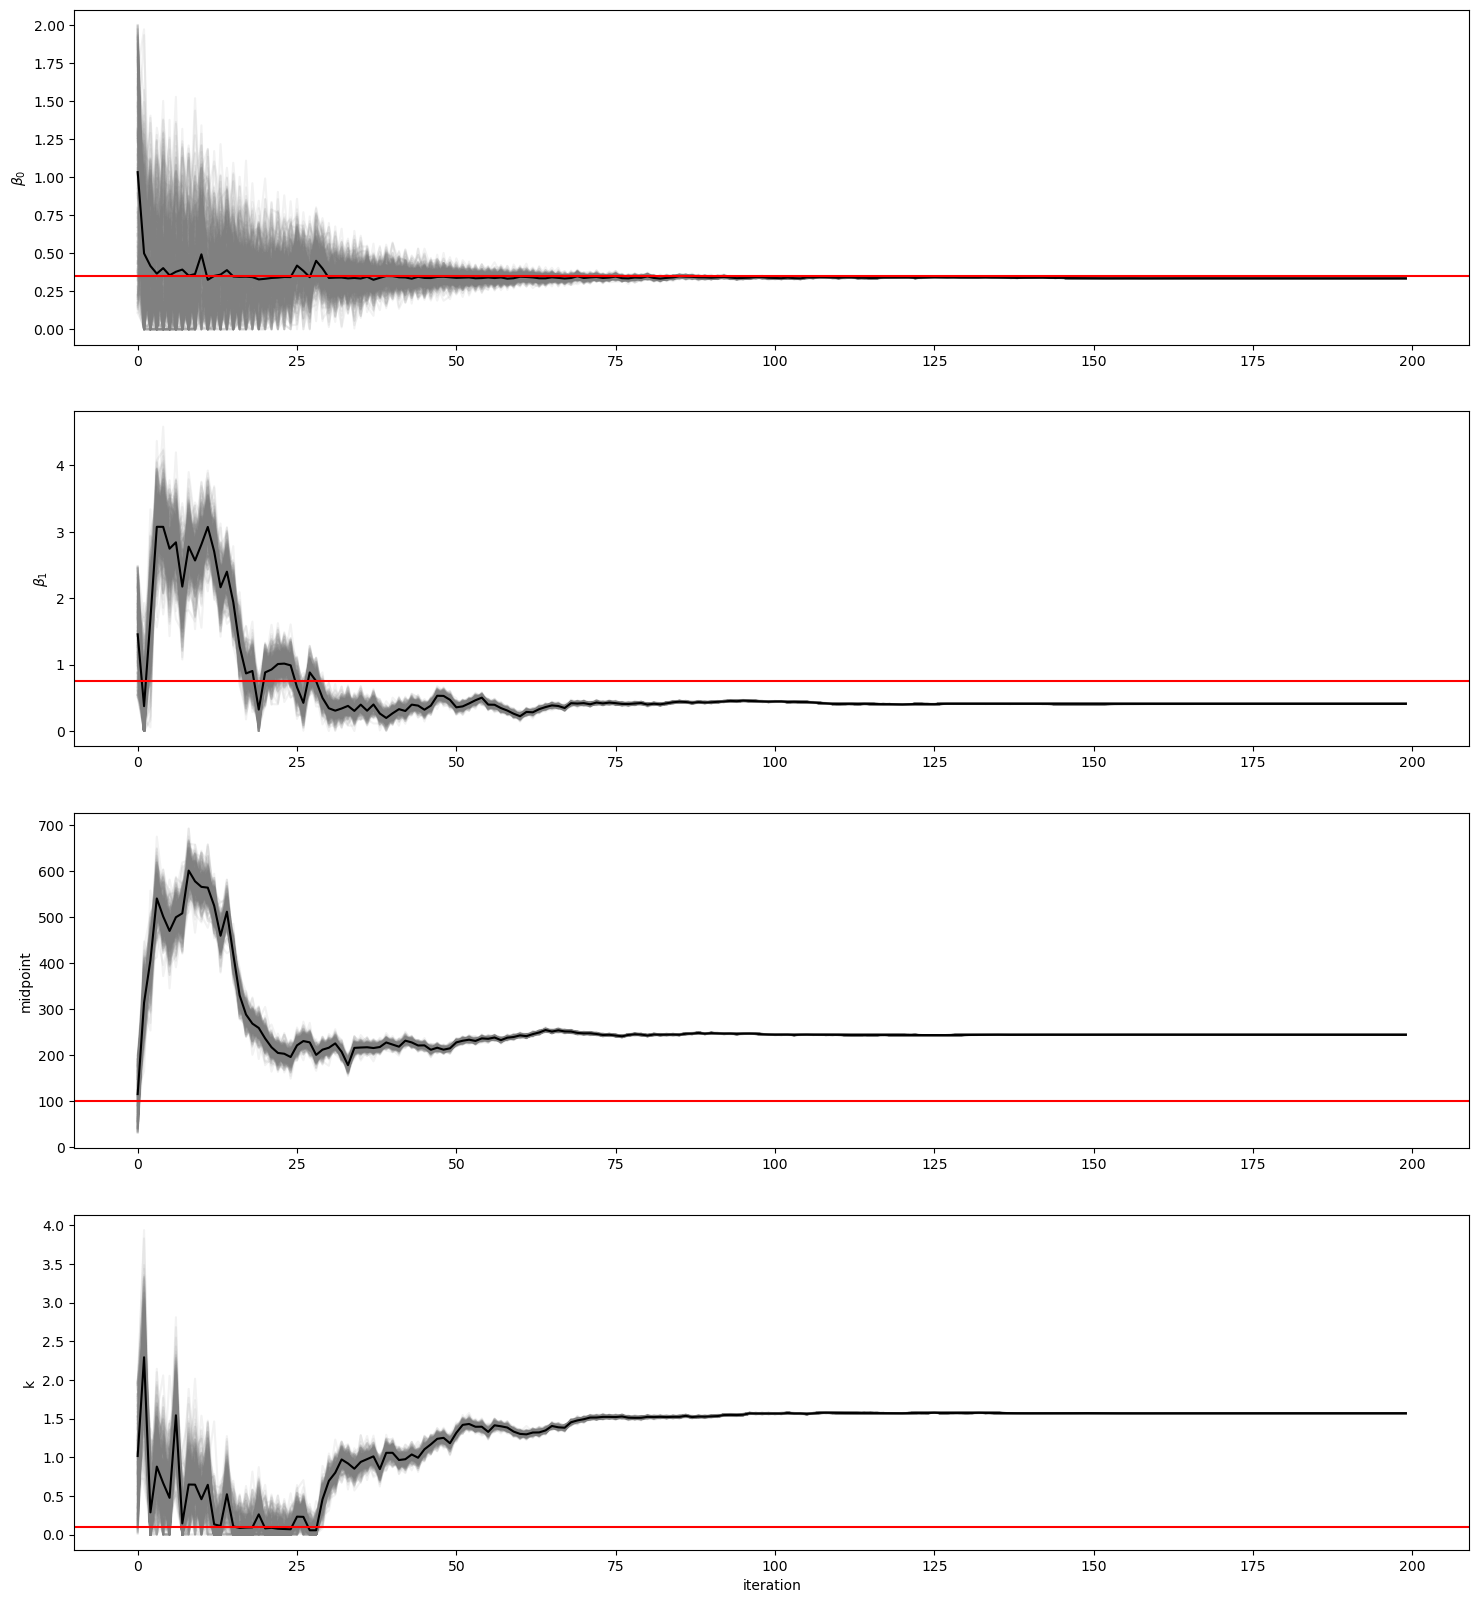

In [117]:
x_list, θ_list, if_list = if_eakf(n_if = 200, avg="last", cooling=0.95)
plot_if_eakf(x_list, θ_list, if_list, title=f"IF-EAKF with {n_if} iterations (mean of last iteration)")

In [118]:
diff = np.asarray([x.i for x in x_list]).T - data.i_true[:-1]
np.sqrt(np.mean((diff)**2))

119.30759750691794

100%|█████████████████████████████| 200/200 [00:28<00:00,  6.98it/s]


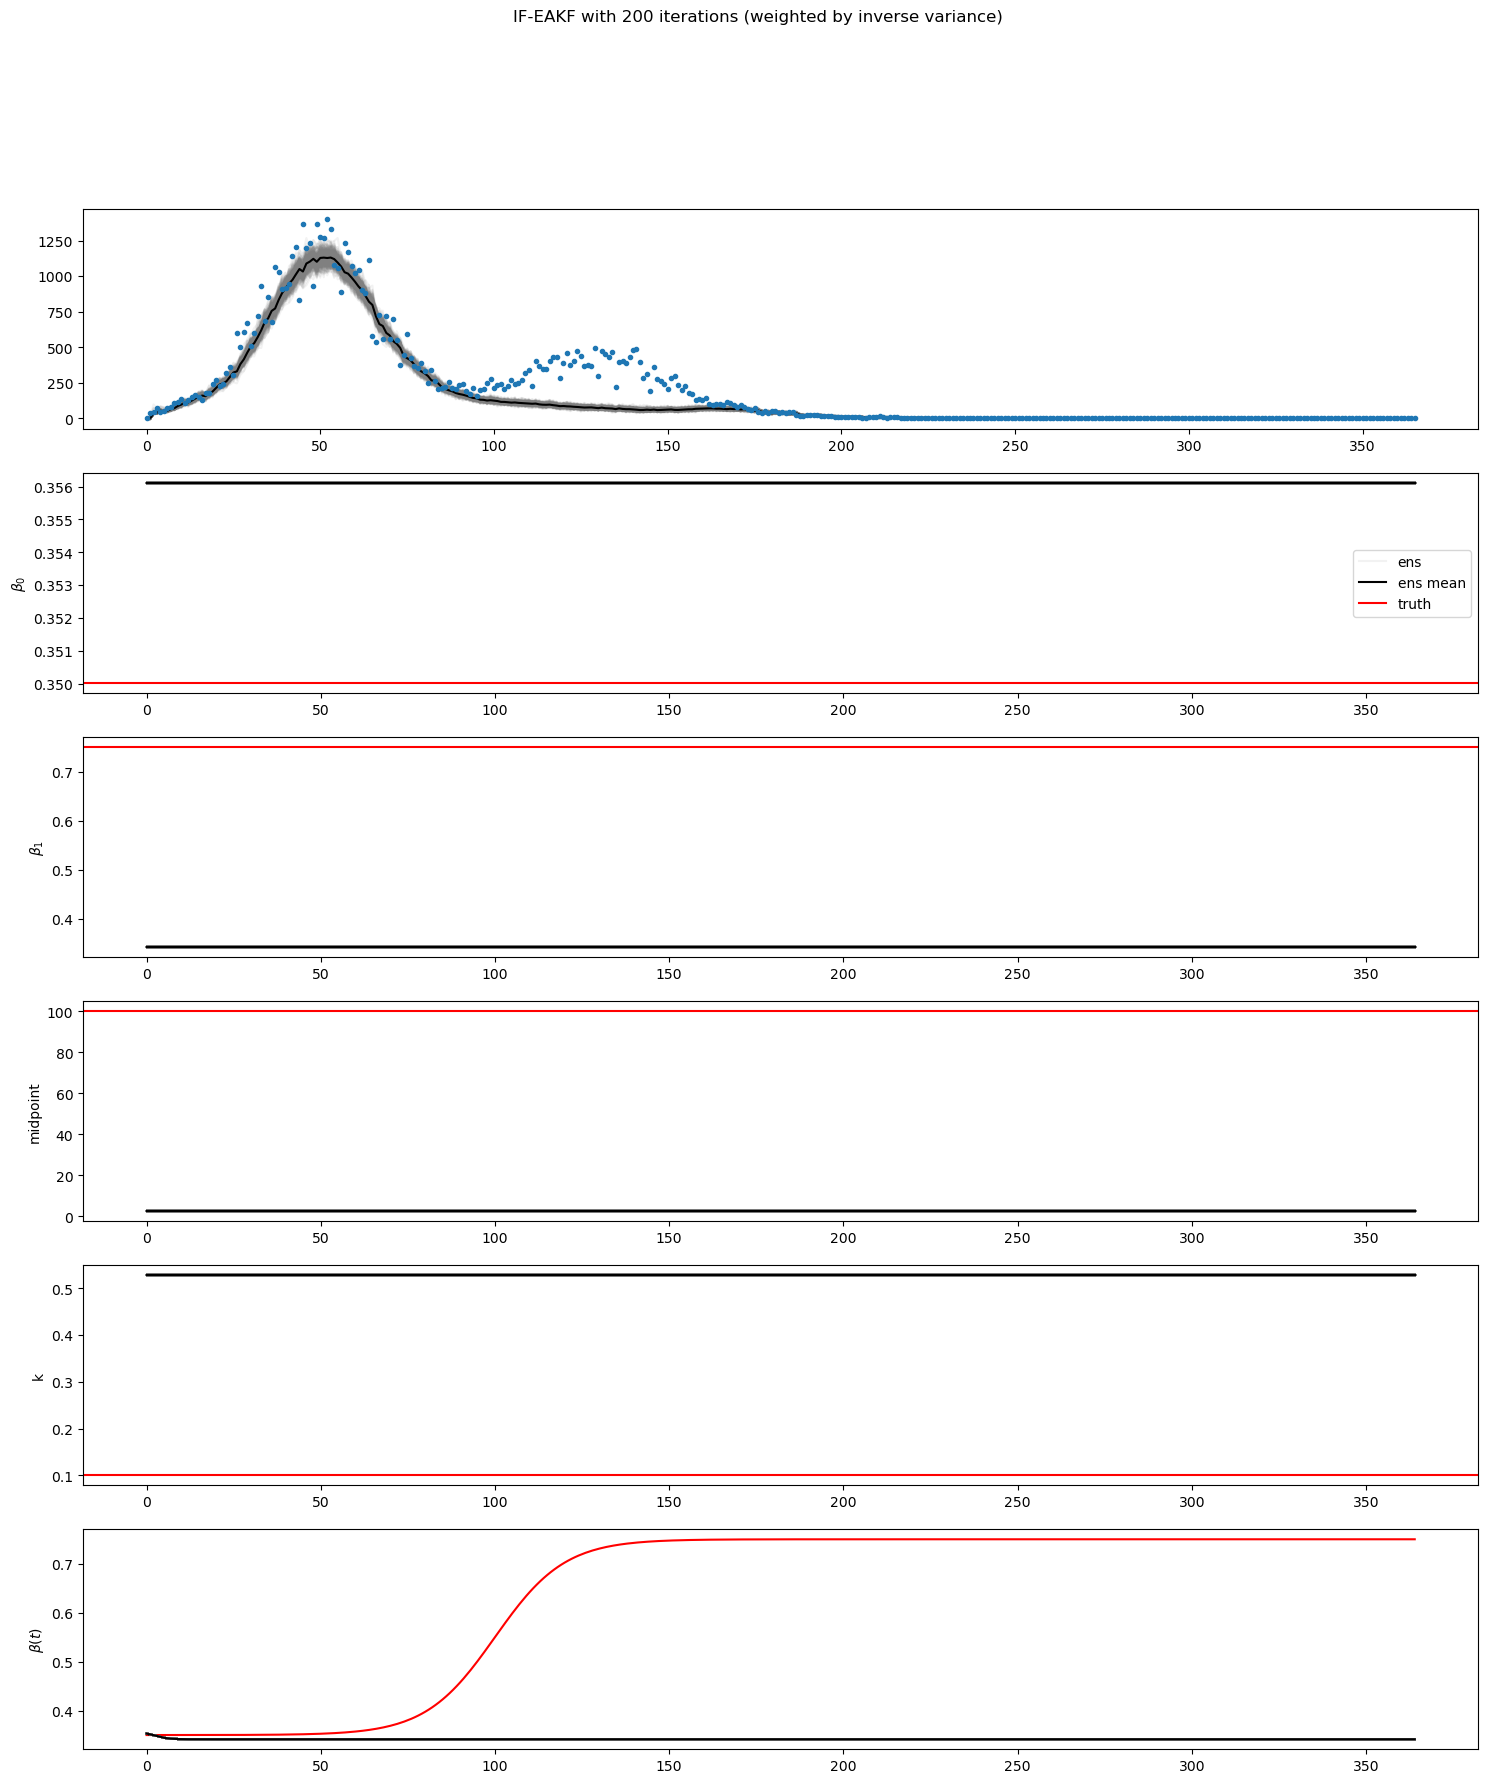

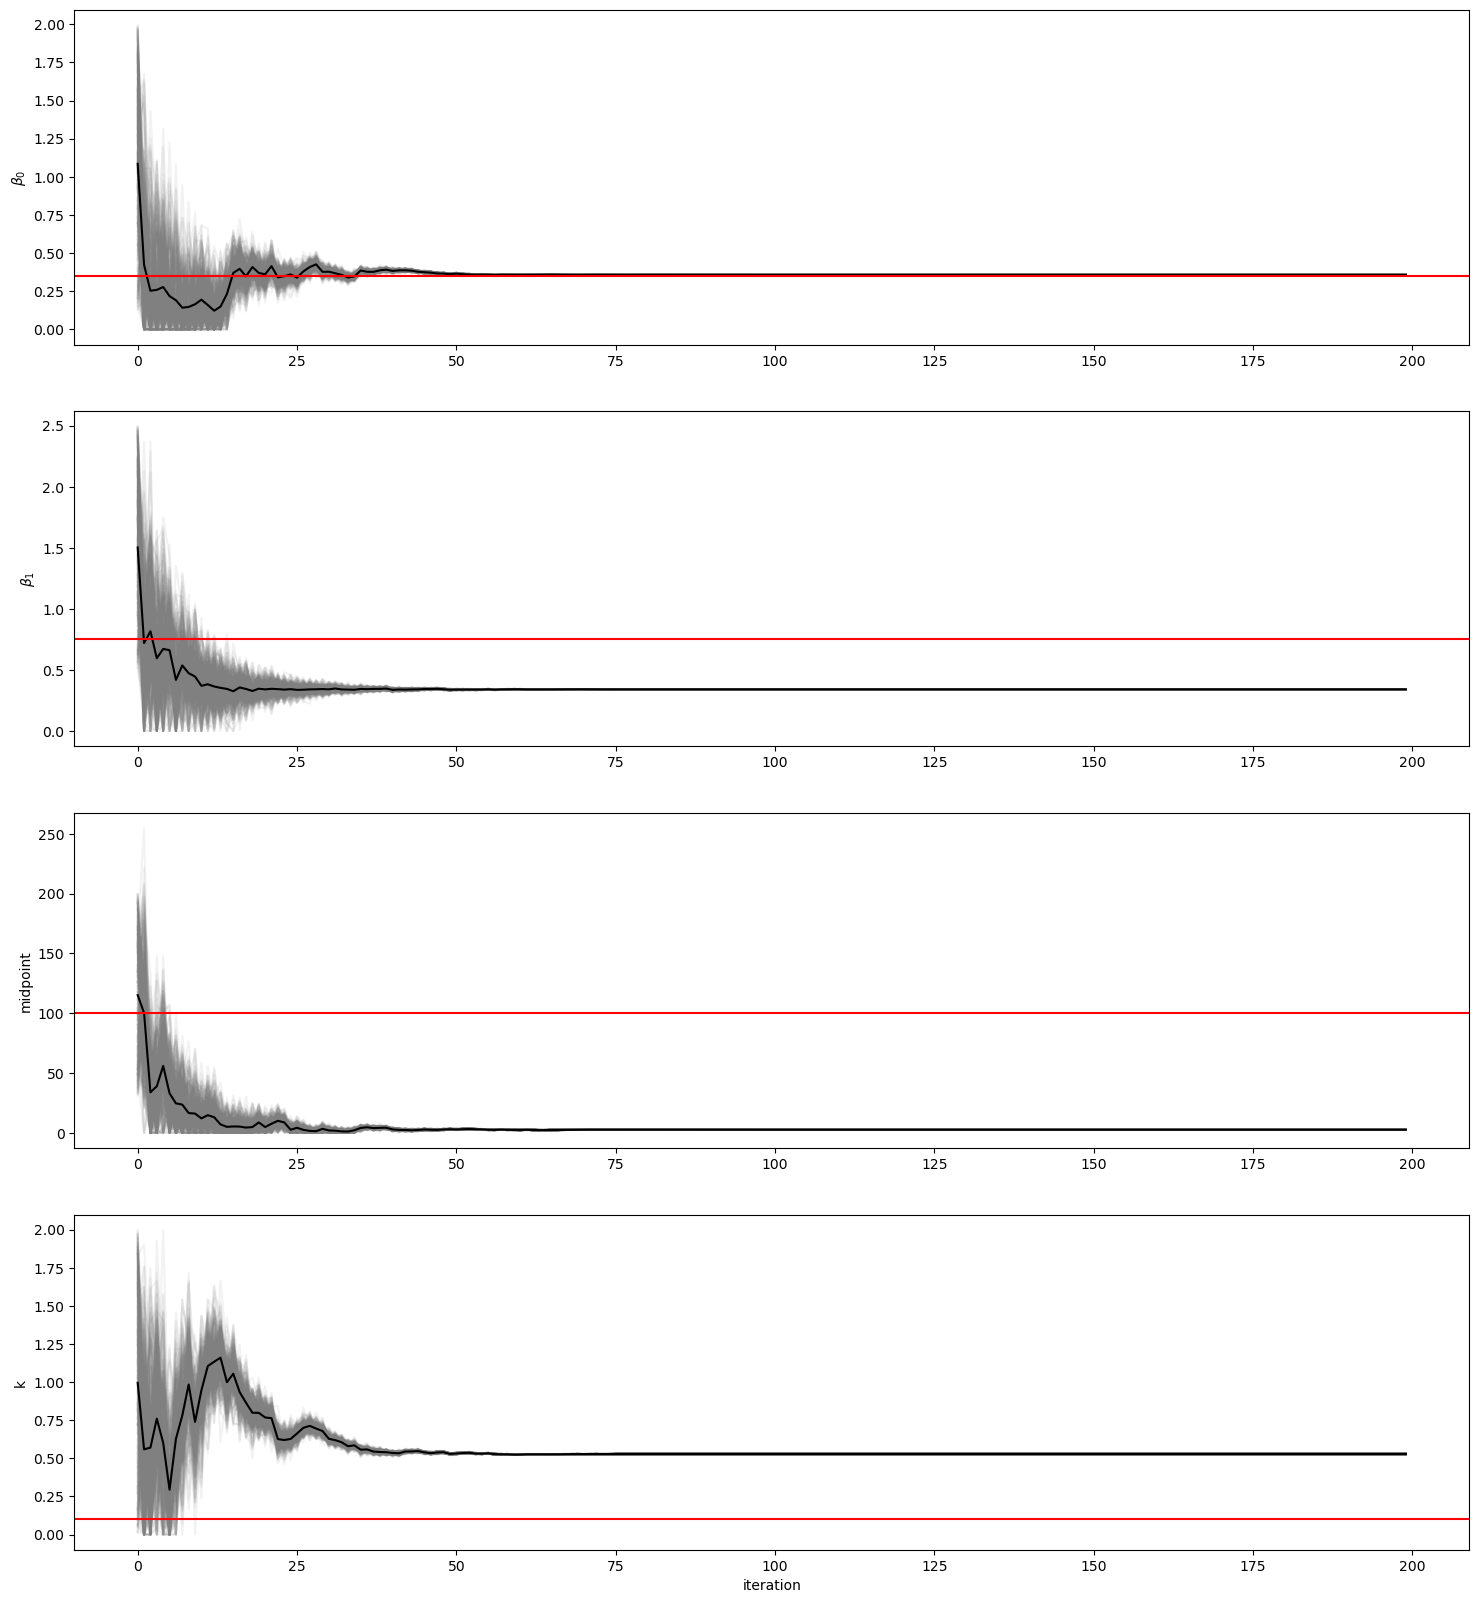

In [119]:
x_list, θ_list, if_list = if_eakf(n_if = 200, avg="weighted", cooling=0.9)
plot_if_eakf(x_list, θ_list, if_list, title=f"IF-EAKF with {n_if} iterations (weighted by inverse variance)")

In [120]:
diff = np.asarray([x.i for x in x_list]).T - data.i_true[:-1]
np.sqrt(np.mean((diff)**2))

117.02697546403233

[TODO] Split time series into x batches and hold out one for predictive validity.


### Run from the beginning each time

In [131]:
def f_beg(t, x, θ, N, dt=1, noise_param=1/25):
    """
    State transition function.
        Args:
            t: time
            x: state space
            θ: parameters
            N: population
            dt: time step in days
    """

    # Stochastic transitions
    beta = θ.beta_0 + (θ.beta_1 - θ.beta_0) / (1 + np.exp(-θ.k*(t - θ.midpoint)))
    
    S = np.array([S0])
    Ir = np.array([I0])
    R = np.array([0])
    i = np.array([0])
    for tt in range(0, t):
        dSI = np.random.poisson(beta[t]*Ir[t]*S[t]/N)
        dIR = np.random.poisson(Ir[t]/t_I)

        S_new = np.clip(S[t]-dSI, 0, N)
        I_new = np.clip(Ir[t]+dSI-dIR, 0, N)
        R_new = np.clip(R[t]+dIR, 0, N)

        # Updates
        x_new = SIR(
            S = np.clip(x.S - dSI, 0, N),
            I = np.clip(x.I + dSI - dIR, 0, N),
            R = np.clip(x.R + dIR, 0, N),
            i = np.clip(dSI, 0, N)
        )

    return x_new

In [ ]:
def eakf_beg():
    x_list = []
    θ_list = []
    for t, date in enumerate(range(data.n_t)):
        if t == 0:
            x = f0(data.N)
            θ = θ0(prior)
        else:
            x = f(t, x, θ, data.N)  # prediction
            y = g(x, α=1)           # analysis
            z = data.i[t]

            # noise_param = 1/100
            # oev = np.random.normal(0, 1) * np.maximum(1., z * noise_param)
            oev = np.maximum(10, z**2/50)
            x, new_i = eakf(x, y, z, oev=oev)
            x = SIR(*x)
            x = clip_states(x)
            x = x._replace(i=new_i)
            θ, _ = eakf(θ, y, z, oev=oev)
            θ = np.clip(θ, 0, None)
            θ = SigmoidModelParams(*θ)

        x_list.append(x)
        θ_list.append(θ)
        
        return x_list, θ_list

## Learn k, fix other params

In [121]:
def θ0_fixk(prior, m=300):
    """
    Initial guess of the parameter space.
        Args:
            prior: prior
            m: number of ensemble members
    """
    beta_0 = (data.rt_0 / data.t_I) * np.ones(m)
    beta_1 = (data.rt_1 / data.t_I) * np.ones(m)
    k = prior['k']['dist'](**prior['k']['args'], size=m)
    midpoint = data.midpoint * np.ones(m)
    
    θ0 = SigmoidModelParams(
        beta_0 = beta_0,
        beta_1 = beta_1,
        midpoint = midpoint,
        k = k,
    )
    return θ0

In [122]:
def f_fixk(t, x, θ, N, dt=1, noise_param=1/25):
    """
    State transition function.
        Args:
            t: time
            x: state space
            θ: parameters
            N: population
            dt: time step in days
    """

    # Stochastic transitions
    beta = (data.rt_0 / data.t_I) + (data.rt_1 / data.t_I - data.rt_0 / data.t_I) / (1 + np.exp(-θ.k*(t - data.midpoint)))
    dSI = np.random.poisson(x.S * x.I/ N * beta) # susceptible to infected
    dIR = np.random.poisson(x.I / data.t_I) # infected to recovered

    # Updates
    x_new = SIR(
        S = np.clip(x.S - dSI, 0, N),
        I = np.clip(x.I + dSI - dIR, 0, N),
        R = np.clip(x.R + dIR, 0, N),
        i = np.clip(dSI, 0, N)
    )

    return x_new

In [123]:
x_list = []
θ_list = []
for t, date in enumerate(range(data.n_t)):
    if t == 0:
        x = f0(data.N)
        θ = θ0_fixk(prior)
    else:
        x = f_fixk(t, x, θ, data.N)  # prediction
        y = g(x, α=1)           # analysis
        z = data.i[t]
        
        # noise_param = 1/100
        # oev = np.random.normal(0, 1) * np.maximum(1., z * noise_param)
        oev = np.maximum(10, z**2/50)
        x, new_i = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = clip_states(x)
        x = x._replace(i=new_i)
        θ, _ = eakf(θ, y, z, oev=oev)
        θ = np.clip(θ, 0, None)
        θ = SigmoidModelParams(*θ)
    
    x_list.append(x)
    θ_list.append(θ)

Text(0, 0.5, '$\\beta(t)$')

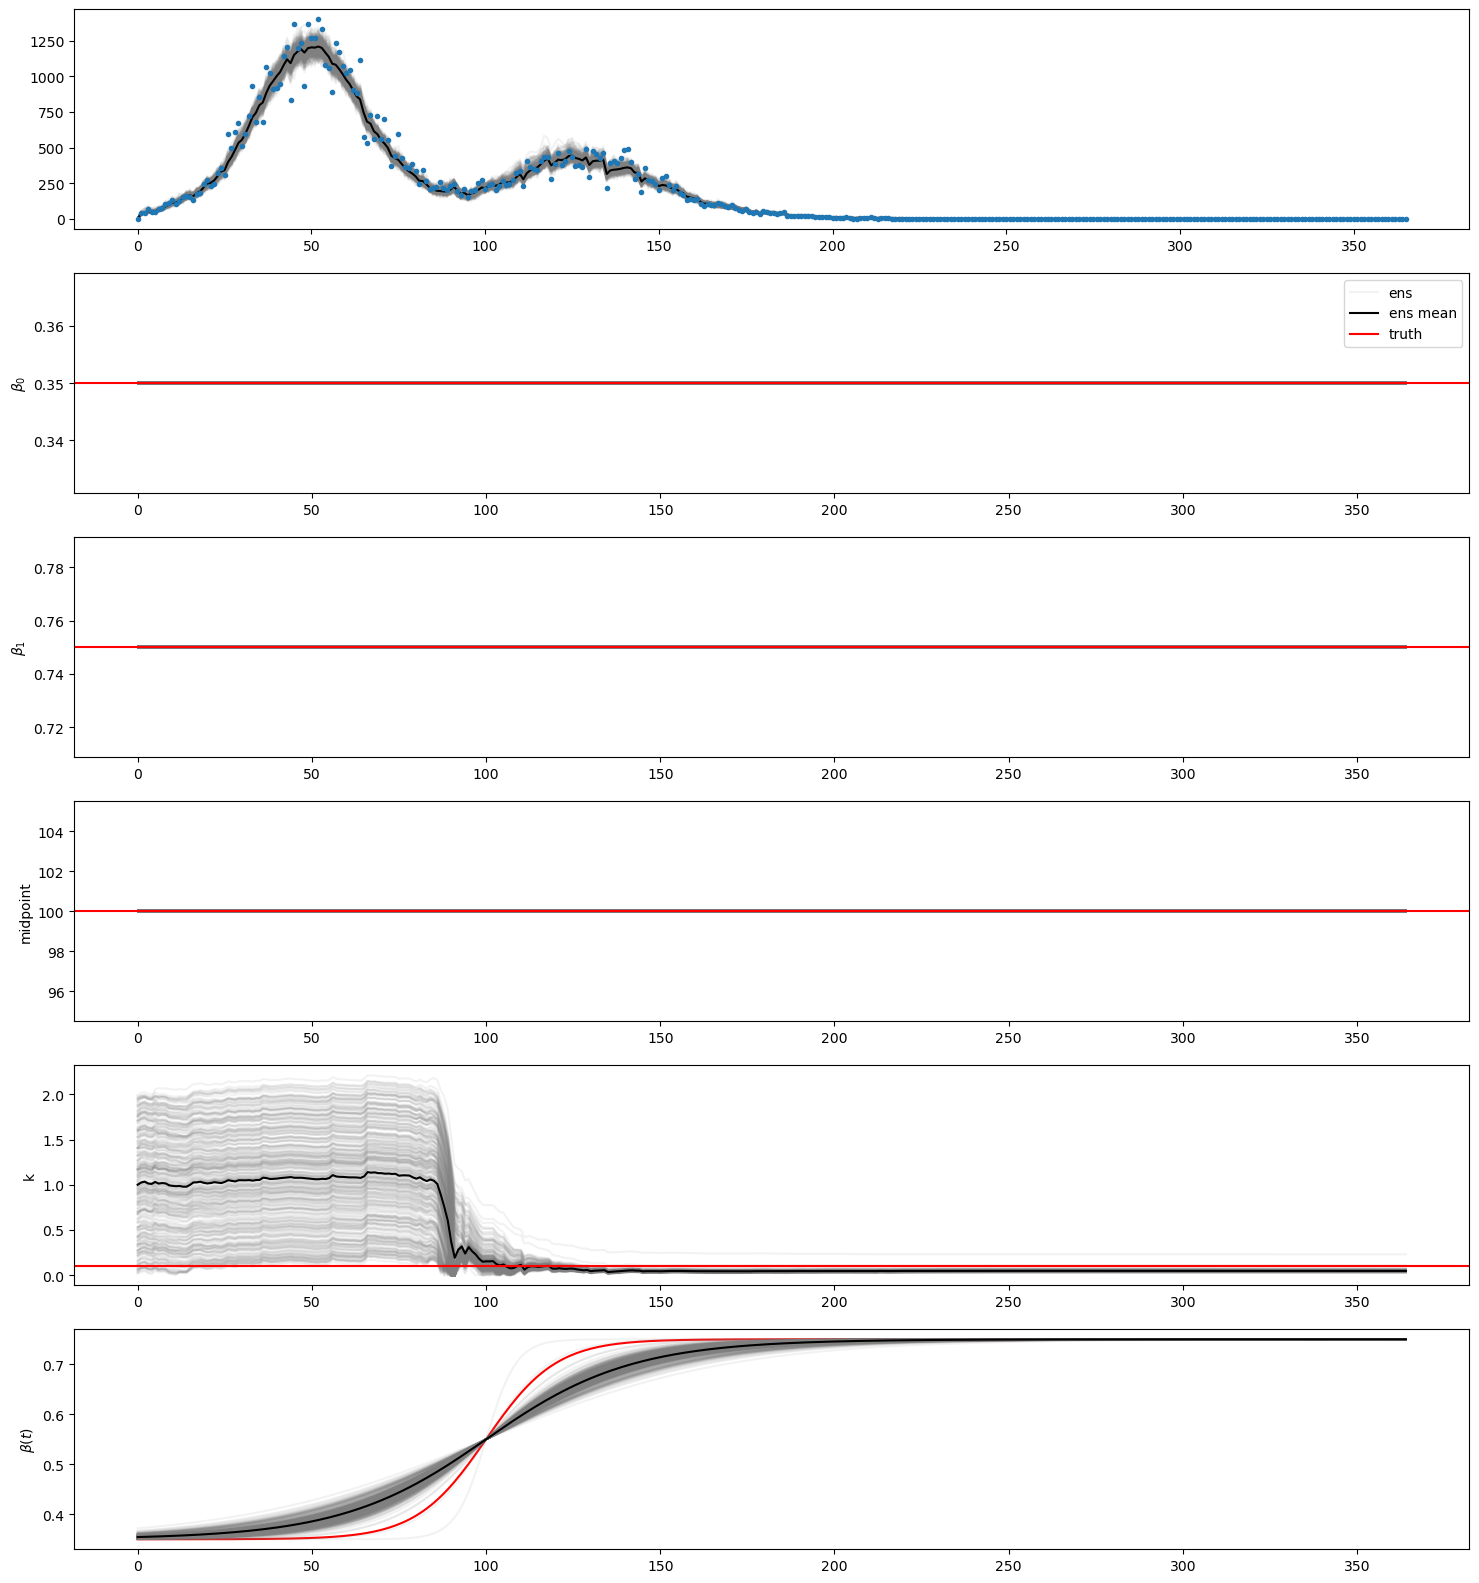

In [124]:
post = θ_list[-1]
t = np.arange(0, data.n_t)
sigmoid = [post.beta_0 + (post.beta_1 - post.beta_0) / (1 + np.exp(-post.k*(tt - post.midpoint))) for tt in t]

fig, ax = plt.subplots(6, figsize=(18,20))
ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')
ax[0].plot(data.i, '.')

ax[1].plot([θ.beta_0 for θ in θ_list], color="gray", alpha=0.1)
ax[1].plot([],[], 'gray', alpha=0.1, label='ens')
ax[1].plot(np.mean([θ.beta_0 for θ in θ_list], axis=1), color='black', label="ens mean")
ax[1].axhline(beta[0], color="red", label="truth")
ax[1].set_ylabel(r"$\beta_0$")
ax[1].legend()

ax[2].plot([θ.beta_1 for θ in θ_list], color="gray", alpha=0.1)
ax[2].plot(np.mean([θ.beta_1 for θ in θ_list], axis=1), color='black')
ax[2].axhline(beta[-1], color="red")
ax[2].set_ylabel(r"$\beta_1$")

ax[3].plot([θ.midpoint for θ in θ_list], color="gray", alpha=0.1)
ax[3].plot(np.mean([θ.midpoint for θ in θ_list], axis=1), color='black')
ax[3].axhline(data.midpoint, color="red")
ax[3].set_ylabel(r"midpoint")

ax[4].plot([θ.k for θ in θ_list], color="gray", alpha=0.1)
ax[4].plot(np.mean([θ.k for θ in θ_list], axis=1), color='black')
ax[4].axhline(data.k, color="red")
ax[4].set_ylabel(r"k")

ax[5].plot(beta, color="red")
ax[5].plot(sigmoid, color="gray", alpha=0.1)
ax[5].plot(np.mean(sigmoid, axis=1), color="black")
ax[5].set_ylabel(r"$\beta(t)$")



In [125]:
diff = np.asarray([x.i for x in x_list]).T - data.i_true[:-1]
np.sqrt(np.mean((diff)**2))

29.10784626956071

In [126]:
def sample_if_fixk(n, mean, Sigma, a=0.99, m=300):
    θ = np.random.multivariate_normal(mean, a**(2*n)*Sigma, size=m)
    θ = np.clip(θ, 0, None)
    θ = SigmoidModelParams(*θ.T)
    beta_0 = (data.rt_0 / data.t_I) * np.ones(m)
    beta_1 = (data.rt_1 / data.t_I) * np.ones(m)
    k = prior['k']['dist'](**prior['k']['args'], size=m)
    midpoint = data.midpoint * np.ones(m)
    
    θ0 = SigmoidModelParams(
        beta_0 = beta_0,
        beta_1 = beta_1,
        midpoint = midpoint,
        k = θ.k,
    )
    return θ0

In [127]:
def if_eakf_fixk(n_if = 200, avg="all", cooling=0.99):
    if_list = []

    for n in tqdm(range(n_if)):

        if n == 0:
            x = f0(data.N)
            θ = θ0_fixk(prior)
        else:
            x = f0(data.N)
            θ = sample_if_fixk(n, θ_mean, Sigma, a=cooling)
        x_list = [x]
        θ_list = [θ]
        for t, date in enumerate(range(1, data.n_t)):
            x = f_fixk(t, x, θ, data.N)  # prediction
            y = g(x, α=1)           # analysis
            z = data.i[t]

            oev = np.maximum(10, z**2/50)
            x, new_i = eakf(x, y, z, oev=oev)
            x = SIR(*x)
            x = clip_states(x)
            x = x._replace(i=new_i)
            θ, _ = eakf(θ, y, z, oev=oev)
            θ = np.clip(θ, 0, None)
            θ = SigmoidModelParams(*θ)

            x_list.append(x)
            θ_list.append(θ)

        if avg == "all":
            θ_mean = np.mean(np.mean(np.asarray(θ_list), axis=2), axis=0)
        elif avg == "last":
            θ_mean = np.mean(np.asarray(θ_list[-1]), axis=1)
        elif avg == "weighted":
            θ_list_array = np.asarray(θ_list)
            weights = 1/np.var(θ_list_array, axis=2)
            θ_mean = np.asarray([np.mean(np.average(θ_list_array[:,i,:], weights=weights[:,i], axis=0)) for i in range(4)])

        if_list.append(θ_list[0])

    if_list = np.asarray(if_list)
    if_list = np.swapaxes(if_list, 0, 1)

    return x_list, θ_list, if_list

100%|█████████████████████████████| 200/200 [00:27<00:00,  7.19it/s]


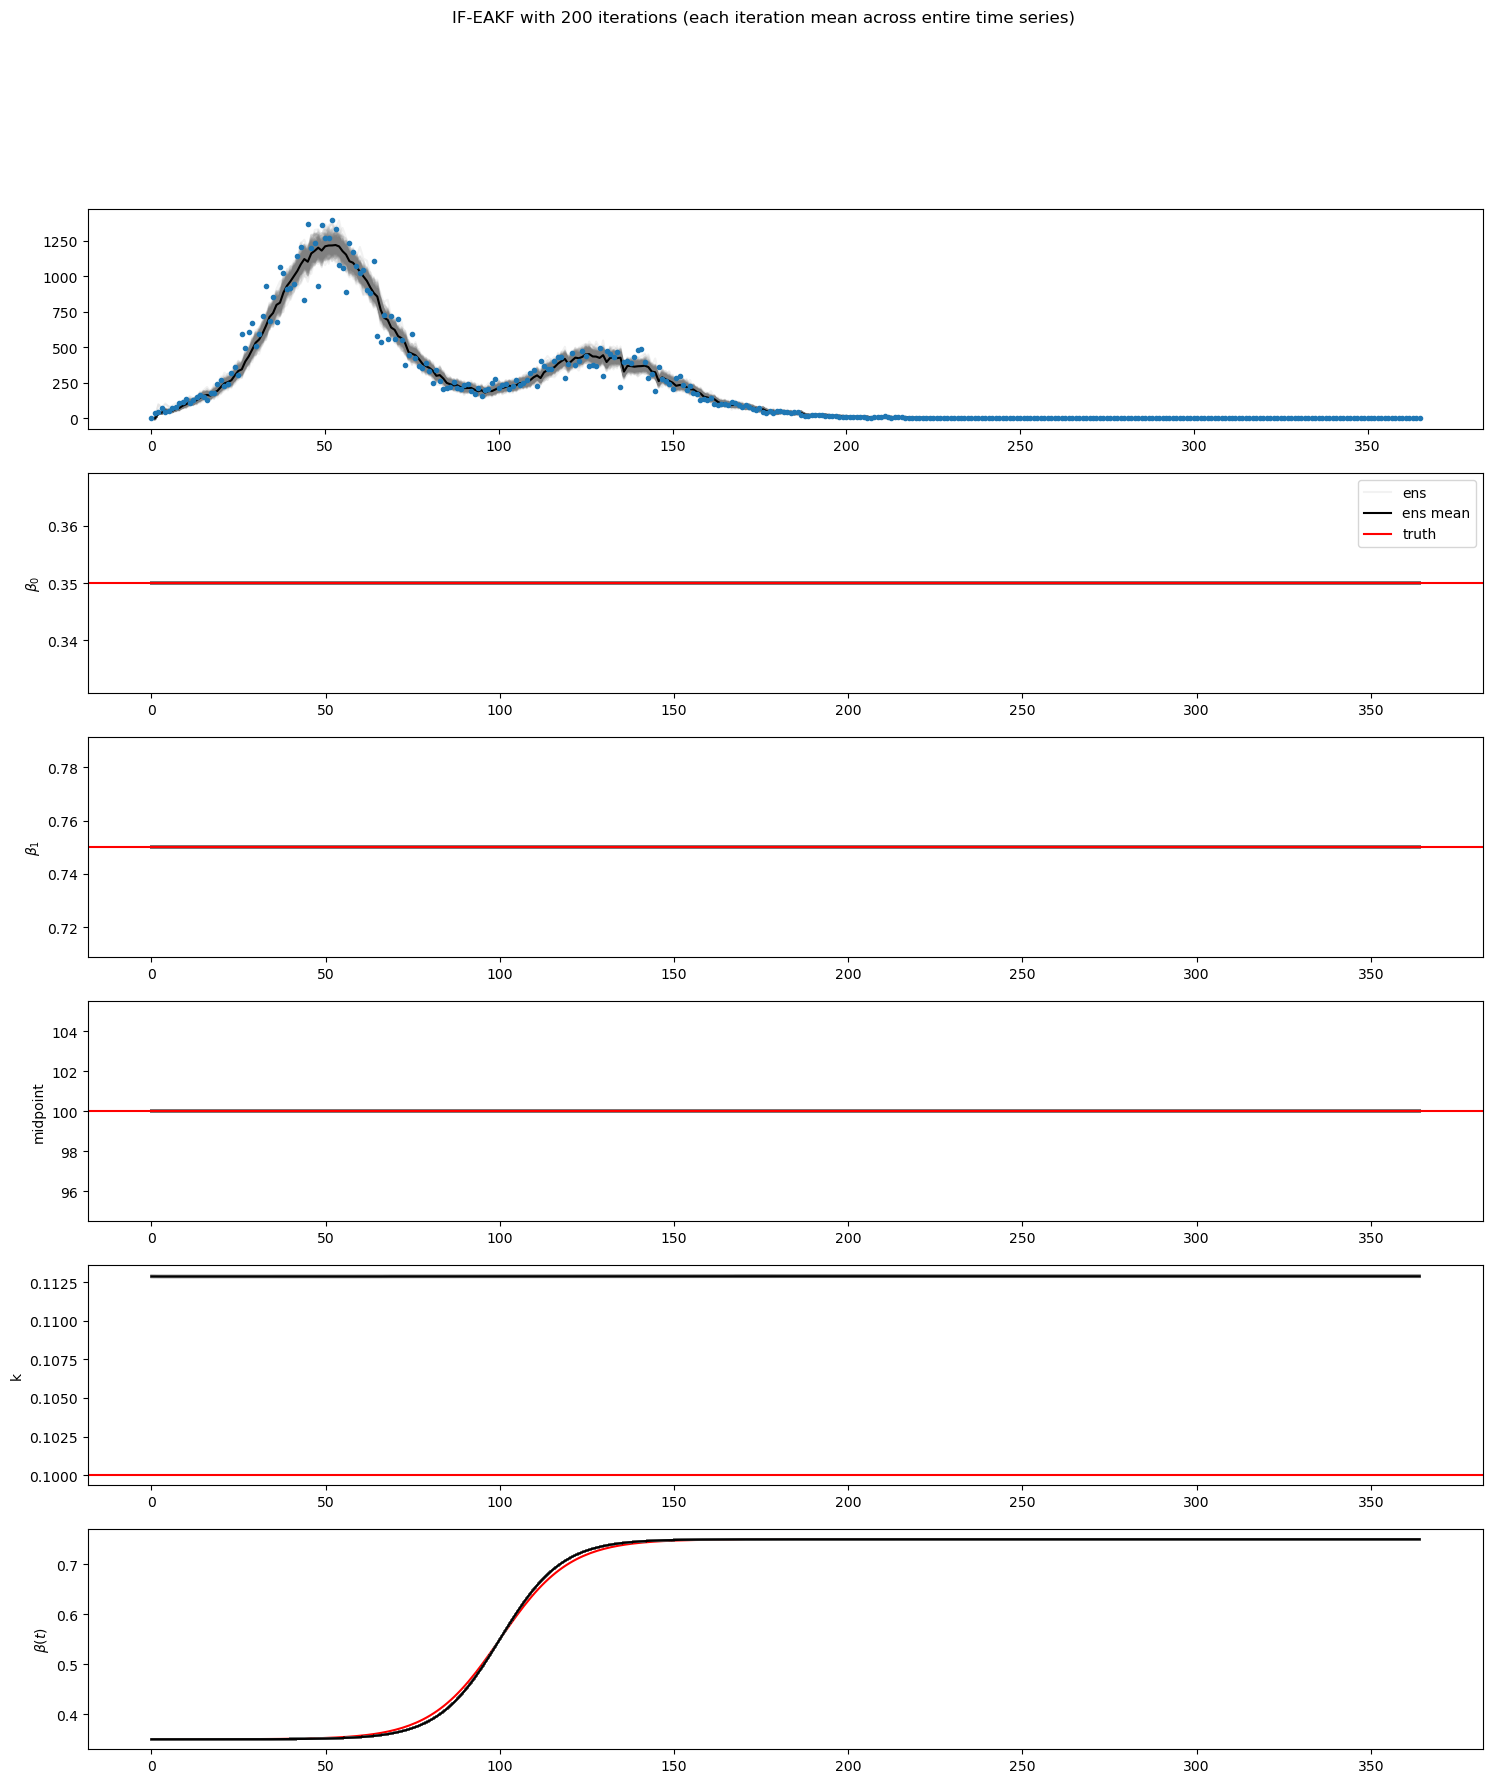

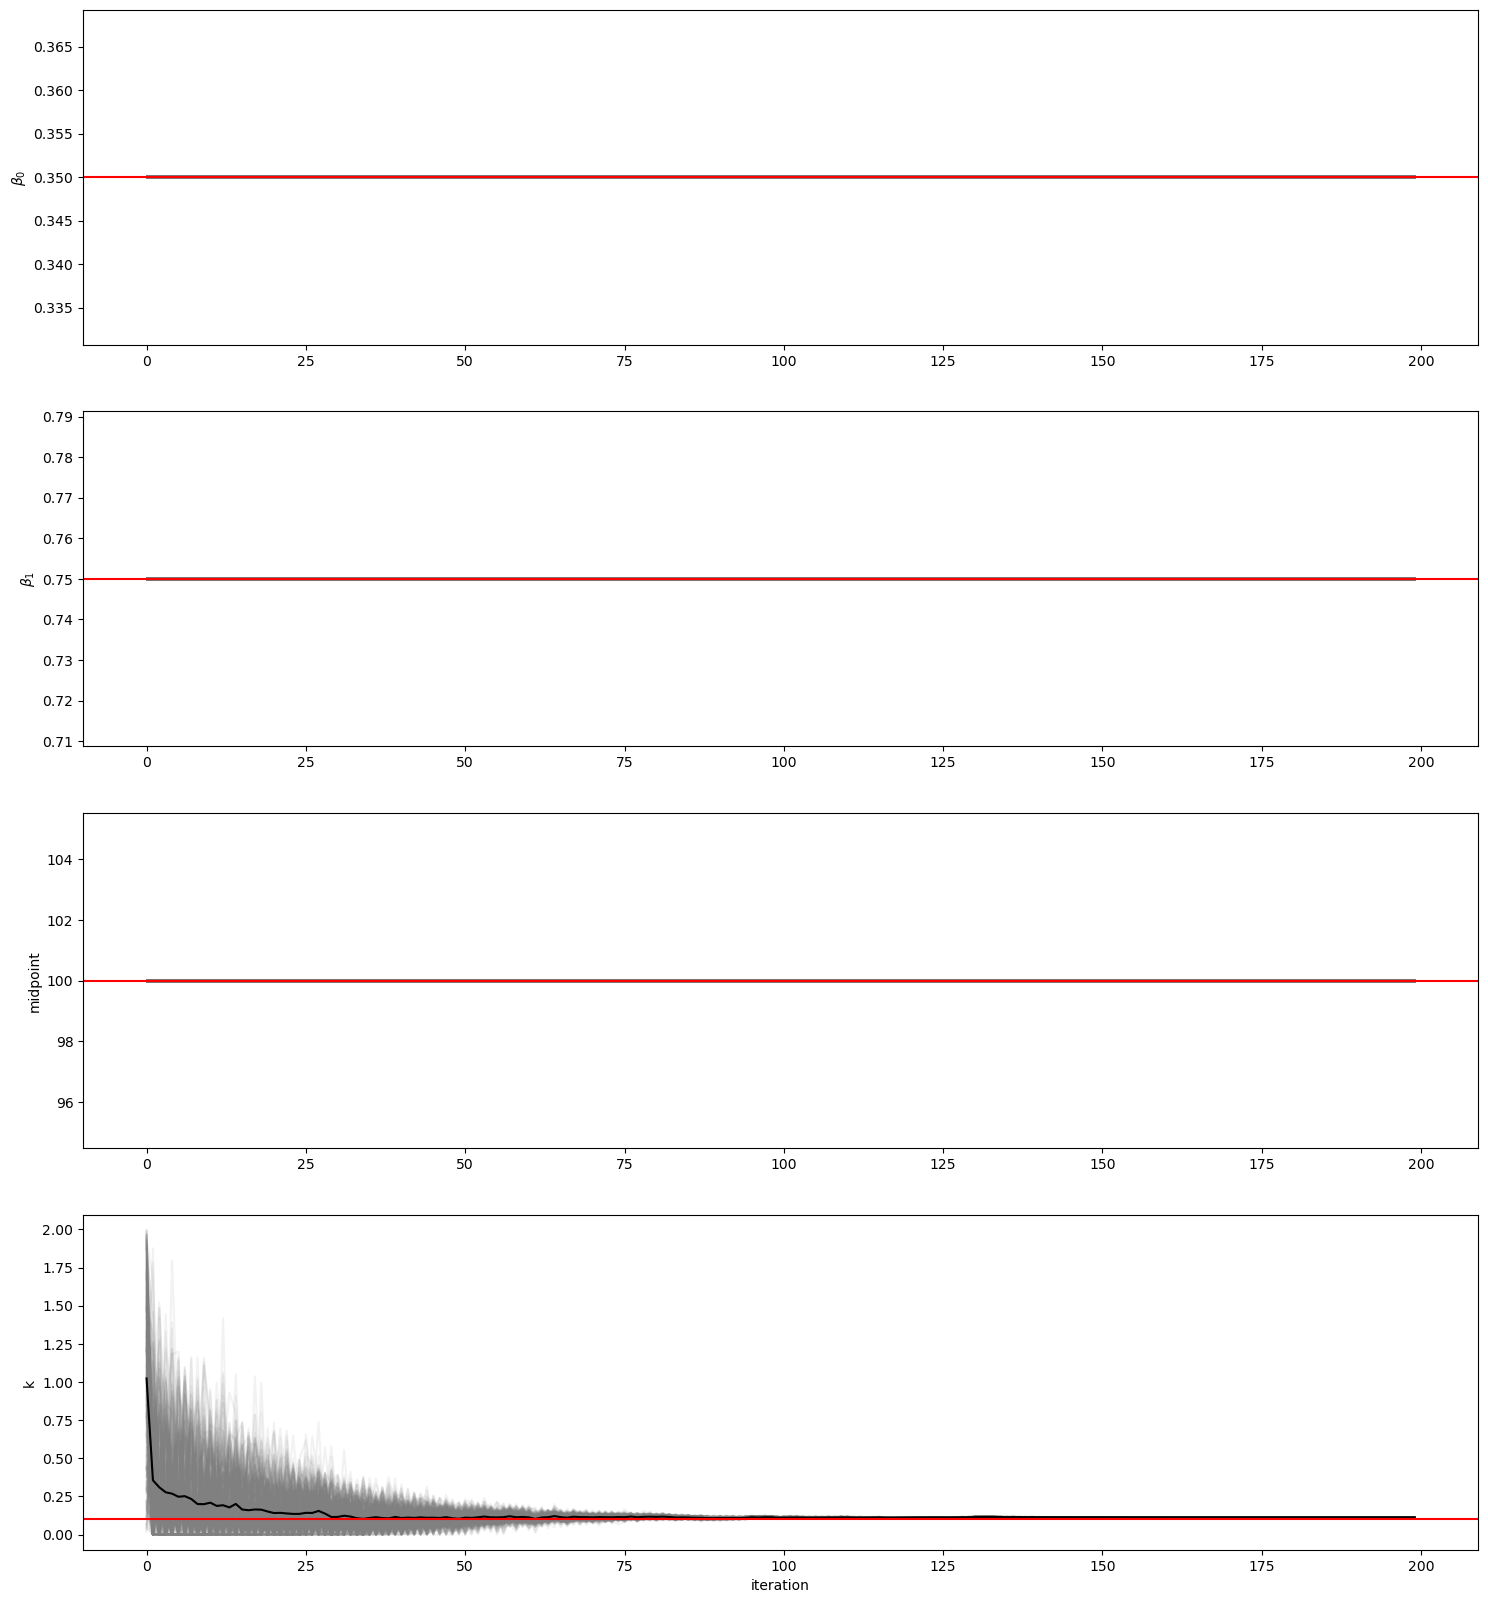

In [128]:
x_list, θ_list, if_list = if_eakf_fixk(n_if = 200, avg="all", cooling=0.95)
plot_if_eakf(x_list, θ_list, if_list)

In [129]:
np.mean(np.asarray([θ.k for θ in θ_list])[-1])

0.1128877551264533

In [130]:
diff = np.asarray([x.i for x in x_list]).T - data.i_true[:-1]
np.sqrt(np.mean((diff)**2))

31.413129764871144

# Ensemble Kalman Filter
1: **Input:** Ensemble size $N$. Initial ensemble $\left\{v_0^{(n)}\right\}_{n=1}^N$. Parameter $s \in\{0,1\}$

2: For $j=0,1, \ldots, J-1$ do the following prediction and analysis steps:
    
3: **Prediction:**
$$
\begin{aligned}
\xi_j^{(n)} & \sim \mathcal{N}(0, \Sigma), \quad \text { i.i.d., } \quad n=1, \ldots, N \\
\widehat{v}_{j+1}^{(n)} & =\Psi\left(v_j^{(n)}\right)+\xi_j^{(n)}, \quad n=1, \ldots, N \\
\widehat{m}_{j+1} & =\frac{1}{N} \sum_{n=1}^N \widehat{v}_{j+1}^{(n)}, \\
\widehat{C}_{j+1} & =\frac{1}{N} \sum_{n=1}^N\left(\widehat{v}_{j+1}^{(n)}-\widehat{m}_{j+1}\right) \otimes\left(\widehat{v}_{j+1}^{(n)}-\widehat{m}_{j+1}\right) .
\end{aligned}
$$

4: **Analysis:**
$$
\begin{aligned}
& \eta_{j+1}^{(n)} \sim \mathcal{N}(0, \Gamma), \quad n=1, \ldots, N, \\
& y_{j+1}^{(n)}=y_{j+1}+s \eta_{j+1}^{(n)}, \quad n=1, \ldots, N \\
& v_{j+1}^{(n)}=\left(I-K_{j+1} H\right) \widehat{v}_{j+1}^{(n)}+K_{j+1} y_{j+1}^{(n)}, \quad n=1, \ldots, N .
\end{aligned}
$$

5: **Output:** Ensembles $\left\{v_j^{(n)}\right\}_{n=1}^N, \quad j=0,1, \ldots, J$

In [ ]:
import numpy as np
from filterpy.kalman import EnsembleKalmanFilter as EnKF

from filterpy.common import Q_discrete_white_noise, Saver

from tqdm import tqdm

In [ ]:
true_params["S0"] / true_params["N"]

In [ ]:
def hx(x):
    """Measurement function
    """
    # α = 1
    # x[3] = np.clip(x[3], 0, true_params["N"])
    return x[3]

def fx(x, dt=1):
    """State transition function
    """
    N = true_params["N"]
    # Stochastic transitions
#     try:
#         dSI = np.random.poisson(x[0] * x[1]/ N * x[4]) # susceptible to infected
#         dIR = np.random.poisson(x[1] / true_params["t_I"]) # infected to recovered
#     except:
#         import pdb; pdb.set_trace()
    
#     noise_param=1/25
#     OEV = np.maximum(1., dSI**2 * noise_param)
#     OEV_sample= np.random.normal(0, 1)
#     i_noise = dSI + OEV_sample * np.sqrt(OEV)

#     # Updates
#     x_new = np.array([
#         np.clip(x[0] - dSI, 0, N),         # S
#         np.clip(x[1] + dSI - dIR, 0, N),   # I
#         np.clip(x[2] + dIR, 0, N),         # R
#         np.clip(i_noise, 0, N),            # i
#         x[4],                              # beta
#         # x[5]                               # t_I = 1/ gamma
#     ])
    
#     if np.any(x_new < 0):
#         import pdb; pdb.set_trace()
    
    # deterministic transitions
    dSI = x[0] * x[1]/ N * x[4]           # S*I/N*beta
    dIR = x[1] / true_params["t_I"]       # I/t_I
    
    x_new = np.array([
        np.clip(x[0] - dSI, 0, N),         # S
        np.clip(x[1] + dSI - dIR, 0, N),   # I
        np.clip(x[2] + dIR, 0, N),         # R
        np.clip(dSI, 0, N),                # i
        x[4],                              # beta
        # x[5]                               # t_I = 1/ gamma
    ])
    

    return x_new

# initial conditions
S0 = np.random.uniform(true_params["N"] * 0.9, true_params["N"], size=300)
I0 = true_params["N"] - S0
R0 = np.zeros(300)
i0 = np.zeros(300)
beta0 = np.random.uniform(0.3, 2, size=300)

x0 = np.array([S0, I0, R0, i0, beta0]).T
x0_mean = np.mean(x0, axis=0)
P = np.cov(x0.T)

f = EnKF(x=x0_mean, P=P, dim_z=1, dt=1, N=300,
         hx=hx, fx=fx)
f.sigmas = x0.copy()

# f.sigmas = np.append(
#     np.clip(f.sigmas[:,:4], 0, true_params["N"]),
#     np.clip(f.sigmas[:,4:], 0.001, None),
#     axis=1
# )
# f.sigmas[:,5] = true_params["t_I"]

std_noise = 10000000
f.R *= std_noise**2     # State measurement noise matrix (scalar)
f.Q *= 100000               # Process noise matrix
f.Q[4,4] = 0.01

chain = []
chain.append(x0.copy())
for t in tqdm(range(1, 366)):
    z = data.i[t]
    f.predict()
    # f.sigmas = np.clip(f.sigmas, 0.001, true_params["N"]).copy()
    noise_param=1/25
    f.update(np.asarray([z]), R=np.sqrt(np.maximum(1., z**2 * noise_param)))
    f.sigmas = np.clip(f.sigmas.copy(), 0.001, true_params["N"])
    chain.append(f.sigmas.copy())

chain = np.array(chain)

In [ ]:
plt.plot(chain[:,:,0], color="gray", alpha=0.1)
plt.plot(data.S, ".")

In [ ]:
plt.plot(chain[:,:,1], color="gray", alpha=0.1)
plt.plot(data.I, ".")

In [ ]:
plt.plot(chain[:,:,3], color="gray", alpha=0.1)
plt.plot(data.i, ".")

In [ ]:
plt.plot(chain[:,:,4], color="gray", alpha=0.1)
plt.plot(np.mean(chain[:,:,4], axis=1), color="red")
plt.plot(data.rt / data.t_I)

# Archize

In [ ]:
class EnsembleKalmanFilter():
    """
    Parameters
    ----------

    x : np.array(dim_x)
        state mean

    P : np.array((dim_x, dim_x))
        covariance of the state

    dim_z : int
        Number of of measurement inputs. For example, if the sensor
        provides you with position in (x,y), dim_z would be 2.

    dt : float
        time step

    m : int
        number of ensembles. Must be greater than 1.

    K : np.array
        Kalman gain

    gx : function gx(x)
        Observation function. May be linear or nonlinear - converts state
        x into a measurement. Return must be an np.array of the same
        dimensionality as the measurement vector.

    fx : function fx(x, dt)
        State transition function. May be linear or nonlinear. Projects
        state x into the next time period. Returns the projected state x
    """

    def __init__(self, x, P, dim_z, dt, m, hx, fx):
        if dim_z <= 0:
            raise ValueError('dim_z must be greater than zero')

        if m <= 0:
            raise ValueError('m must be greater than zero')

        dim_x = len(x)
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.dt = dt
        self.m = m
        self.gx = gx
        self.fx = fx
        self.K = np.zeros((dim_x, dim_z))
        self.z = np.array([[None]*self.dim_z]).T
        self.S = np.zeros((dim_z, dim_z))   # system uncertainty
        self.SI = np.zeros((dim_z, dim_z))  # inverse system uncertainty

        self.initialize(x, P)
        self.Q = eye(dim_x)       # process uncertainty
        self.R = eye(dim_z)       # state uncertainty
        self.inv = np.linalg.inv

        # used to create error terms centered at 0 mean for state and measurement
        self._mean = np.zeros(dim_x)
        self._mean_z = np.zeros(dim_z)
    
    def initialize(self, x, P):
        """
        Initializes the filter with the specified mean and
        covariance. Only need to call this if you are using the filter
        to filter more than one set of data; this is called by __init__

        Parameters
        ----------

        x : np.array(dim_z)
            state mean

        P : np.array((dim_x, dim_x))
            covariance of the state
        """

        if x.ndim != 1:
            raise ValueError('x must be a 1D array')

        self.sigmas = multivariate_normal(mean=x, cov=P, size=self.m)
        self.x = x
        self.P = P

        # these will always be a copy of x,P after predict() is called
        self.x_prior = self.x.copy()
        self.P_prior = self.P.copy()

        # these will always be a copy of x,P after update() is called
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()


    def update(self, z, R=None):
        """
        Add a new measurement (z) to the kalman filter. If z is None, nothing
        is changed.

        Parameters
        ----------

        z : np.array
            measurement for this update.

        R : np.array, scalar, or None
            Optionally provide R to override the measurement noise for this
            one call, otherwise  self.R will be used.
        """

        if z is None:
            self.z = np.array([[None]*self.dim_z]).T
            self.x_post = self.x.copy()
            self.P_post = self.P.copy()
            return

        if R is None:
            R = self.R
        if np.isscalar(R):
            R = eye(self.dim_z) * R

        N = self.N
        dim_z = len(z)
        sigmas_h = zeros((N, dim_z))

        # transform sigma points into measurement space
        for i in range(N):
            sigmas_h[i] = self.hx(self.sigmas[i])

        z_mean = np.mean(sigmas_h, axis=0)

        P_zz = 0
        for sigma in sigmas_h:
            s = sigma - z_mean
            P_zz += outer(s, s)
        P_zz = P_zz / (N-1) + R
        self.S = P_zz
        self.SI = self.inv(self.S)


        P_xz = 0
        for i in range(N):
            P_xz += outer(self.sigmas[i] - self.x, sigmas_h[i] - z_mean)
        P_xz /= N-1

        self.K = dot(P_xz, self.inv(P_zz))

        e_r = multivariate_normal(self._mean_z, R, N)
        for i in range(N):
            self.sigmas[i] += dot(self.K, z + e_r[i] - sigmas_h[i])

        self.x = np.mean(self.sigmas, axis=0)
        self.P = self.P - dot(dot(self.K, P_zz), self.K.T)

        # save measurement and posterior state
        self.z = deepcopy(z)
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()


    def predict(self):
        """ Predict next position. """

        N = self.N
        for i, s in enumerate(self.sigmas):
            self.sigmas[i] = self.fx(s, self.dt)

        e = multivariate_normal(self._mean, self.Q, N)
        self.sigmas += e

        P = 0
        for s in self.sigmas:
            sx = s - self.x
            P += outer(sx, sx)

        self.P = P / (N-1)

        # save prior
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)


    def __repr__(self):
        return '\n'.join([
            'EnsembleKalmanFilter object',
            pretty_str('dim_x', self.dim_x),
            pretty_str('dim_z', self.dim_z),
            pretty_str('dt', self.dt),
            pretty_str('x', self.x),
            pretty_str('P', self.P),
            pretty_str('x_prior', self.x_prior),
            pretty_str('P_prior', self.P_prior),
            pretty_str('Q', self.Q),
            pretty_str('R', self.R),
            pretty_str('K', self.K),
            pretty_str('S', self.S),
            pretty_str('sigmas', self.sigmas),
            pretty_str('hx', self.hx),
            pretty_str('fx', self.fx)
            ])
    

## SIR Dynamics

\begin{array}{l}
\frac{d S}{d t}=-\frac{\beta(t) I S}{N} \\
\frac{d I}{d t}=\frac{\beta(t) I S}{N}-\gamma I, \\
\frac{d R}{d t}=\gamma I
\end{array}.

In [ ]:
SIR = collections.namedtuple(
  typename='SIRComponents',
  field_names=[
    'susceptible',              # S
    'infectious',               # I
    'recovered',                # R
    'daily_new_documented_infectious'])

ModelParams = collections.namedtuple(
    typename='ModelParams',
    field_names=[
      'beta',                        # Beta
      'average_infection_duration'   # D = 1/gamma
    ]
)

In [ ]:
def sample_state_deltas(
    state, population, params, seed, is_deterministic=False):
  """Computes one-step change in state, including Poisson sampling.
  
  Note that this is coded to support vectorized evaluation on arbitrary-shape
  batches of states.  This is useful, for example, for running multiple
  independent replicas of this model to compute credible intervals for the
  parameters.  We refer to the arbitrary batch shape with the conventional
  `B` in the parameter documentation below.  This function also, of course,
  supports broadcasting over the batch shape.

  Args:
    state: A `SIRComponents` tuple with fields Tensors of shape
      B + [num_locations] giving the current disease state.
    population: A Tensor of shape B + [num_locations] giving the current city
      populations.
    params: A `ModelParams` tuple with fields Tensors of shape B giving the
      global parameters for the current EAKF run.
    seed: Initial entropy for pseudo-random number generation.  The Poisson
      sampling is repeatable by supplying the same seed.
    is_deterministic: A `bool` flag to turn off Poisson sampling if desired.

  Returns:
    delta: A `SIRComponents` tuple with fields Tensors of shape
      B + [num_locations] giving the one-day changes in the state, according
      to equations 1-4 above (including Poisson noise per Li et al).
  """
  infectious_fraction = state.infectious / population

  # Helper for sampling the Poisson-variate terms.
  seeds = samplers.split_seed(seed, n=11)
  if is_deterministic:
    def sample_poisson(rate):
      return rate
  else:
    def sample_poisson(rate):
      return tfd.Poisson(rate=rate).sample(seed=seeds.pop())

  dSI = sample_poisson(params.beta * infectious_fraction * state.susceptible)
  dIR = sample_poisson(state.infectious / params.average_infection_duration)

  # The final state_deltas
  return SIRComponents(
      susceptible=-dSI,
      infectious=dSI - dIR,
      recovered=dIR,
      daily_new_documented_infectious=dSI)

In [ ]:
@tf.function(autograph=False)
def rk4_one_step(state, population, mobility_matrix, params, seed):
  """Implement one step of RK4, wrapped around a call to sample_state_deltas."""
  # One seed for each RK sub-step
  seeds = samplers.split_seed(seed, n=4)

  deltas = tf.nest.map_structure(tf.zeros_like, state)
  combined_deltas = tf.nest.map_structure(tf.zeros_like, state)

  for a, b in zip([1., 2, 2, 1.], [6., 3., 3., 6.]):
    next_input = tf.nest.map_structure(
        lambda x, delta, a=a: x + delta / a, state, deltas)
    deltas = sample_state_deltas(
        next_input,
        population,
        params,
        seed=seeds.pop(), is_deterministic=False)
    combined_deltas = tf.nest.map_structure(
        lambda x, delta, b=b: x + delta / b, combined_deltas, deltas)

  return tf.nest.map_structure(
      lambda s, delta: s + tf.round(delta),
      state, combined_deltas)

In [ ]:
def initialize_state(num_particles, num_batches, seed):
  """Initialize the state for a batch of EAKF runs.
  
  Args:
    num_particles: `int` giving the number of particles for the EAKF.
    num_batches: `int` giving the number of independent EAKF runs to
      initialize in a vectorized batch.
    seed: PRNG entropy.
    
  Returns:
    state: A `SIRComponents` tuple with Tensors of shape [num_particles,
      num_batches, num_cities] giving the initial conditions in each
      city, in each filter particle, in each batch member.
  """
  state_shape = [num_particles, num_batches]
  susceptible = initial_population * np.ones(state_shape, dtype=np.float32)
  infectious = np.zeros(state_shape, dtype=np.float32)
  daily_new_documented_infectious = np.zeros(state_shape, dtype=np.float32)

  # Following Li et al, initialize Wuhan with up to 2000 people exposed
  # and another up to 2000 undocumented infectious.
  rng = np.random.RandomState(seed[0] % (2**31 - 1))
  wuhan_exposed = rng.randint(
      0, 2001, [num_particles, num_batches]).astype(np.float32)
  wuhan_undocumented_infectious = rng.randint(
      0, 2001, [num_particles, num_batches]).astype(np.float32)
 
  # Also following Li et al, initialize cities adjacent to Wuhan with three
  # days' worth of additional exposed and undocumented-infectious cases,
  # as they may have traveled there before the beginning of the modeling
  # period.
  exposed = 3 * mobility_matrix_over_time[
      WUHAN_IDX, :, 0] * wuhan_exposed[
          ..., np.newaxis] / initial_population[WUHAN_IDX]
  undocumented_infectious = 3 * mobility_matrix_over_time[
      WUHAN_IDX, :, 0] * wuhan_undocumented_infectious[
          ..., np.newaxis] / initial_population[WUHAN_IDX]

  exposed[..., WUHAN_IDX] = wuhan_exposed
  undocumented_infectious[..., WUHAN_IDX] = wuhan_undocumented_infectious

  # Following Li et al, we do not remove the initial exposed and infectious
  # persons from the susceptible population.
  return SIRComponents(
      susceptible=tf.constant(susceptible),
      exposed=tf.constant(exposed),
      documented_infectious=tf.constant(documented_infectious),
      undocumented_infectious=tf.constant(undocumented_infectious),
      daily_new_documented_infectious=tf.constant(daily_new_documented_infectious))

def update_params(num_particles, num_batches,
                  prev_params, parameter_variance, seed):
  """Update the global parameters between EAKF runs.

  Args:
    num_particles: `int` giving the number of particles for the EAKF.
    num_batches: `int` giving the number of independent EAKF runs to
      initialize in a vectorized batch.
    prev_params: A `ModelParams` tuple of the parameters used for the previous
      EAKF run.
    parameter_variance: A `ModelParams` tuple specifying how much to drift
      each parameter.
    seed: PRNG entropy.
    
  Returns:
    params: A `ModelParams` tuple with fields Tensors of shape
      [num_particles, num_batches] giving the global parameters
      to use for the next batch of EAKF runs.
  """
  # Initialize near the previous set of parameters. This is the first step
  # in Iterated Filtering.
  seeds = tf.nest.pack_sequence_as(
      prev_params, samplers.split_seed(seed, n=len(prev_params)))
  return tf.nest.map_structure(
      lambda x, v, seed: x + tf.math.sqrt(v) * tf.random.stateless_normal([
          num_particles, num_batches, 1], seed=seed),
      prev_params, parameter_variance, seeds)